# Download and Unzip Function

To see the download and unzipping progress

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lemma-dev-utils
!pip install pyspark
!pip install shapely==1.8.5 -U
!pip install rtree
!pip install scikit-mobility

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Downloading the Dataset

In [3]:
with open('dataset_url.txt', 'r') as url_file:
    url = url_file.read()

In [4]:
from lemma_dev_utils import download_unzip, download 
import os

path = 'dataset'

download_unzip(path, url)
os.chdir(path)

Unzipping train_labels.csv: 100%|##########| 30752769/30752769 [00:00<00:00, 48191458.24it/s]


# Setting up Spark

In [5]:
# constant that sets the fraction of sample to collect when intending to manage data out of spark
SAMPLE_FRAC = 0.01

In [6]:
from lemma_dev_utils import download_unzip, download
import os

import itertools
import numpy as np
import random
import seaborn as sns
import re
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, lit

import math
from math import exp, e
from statistics import mean

from pyspark.sql import SparkSession

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report as cr
from collections import Counter

from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import DoubleType
from pyspark.ml.functions import vector_to_array

import pyspark.sql.functions as f
from pyspark.sql.functions import variance, col, lit, when, udf

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import ClusteringEvaluator

from pyspark.ml.clustering import BisectingKMeans

from pyspark.ml.feature import StringIndexer, VectorIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.feature import PCA

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest

from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [7]:
def compute_metrics(labelCol="target", predictionCol="prediction", metricLabel = 1):
    """
    Returning a dictionary with most relevant evaluation metrics
    """

    class_report = dict()
    for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
        evaluator = MulticlassClassificationEvaluator(labelCol=labelCol,
                                                      predictionCol=predictionCol,
                                                      metricName=metric,
                                                      metricLabel = metricLabel)

        class_report[metric] = evaluator.evaluate(predictions)
    return class_report 

In [8]:
def get_ytest_ypred(target_prediction = ['target', 'prediction']):
    """
    Returning y_test and y_pred lists
    """
    target, prediction = target_prediction
    
    lists = predictions.select(target_prediction)
    lists = lists.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()
    y_test = [row[target] for row in lists]
    y_pred = [row[prediction] for row in lists]
    return y_test, y_pred

In [9]:
def plot_conf_matrix(palette, title = '', target_prediction = ['prediction', 'target']):
    """ 
    Plots Confusion Matrix.
    From documentation: confusionMatrix() take as parameter an RDD of (prediction, label) pairs
    """

    pred_and_labels = predictions.select(target_prediction)
    metrics = MulticlassMetrics(pred_and_labels.rdd.map(tuple))
    confusion_matrix_to_plot = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_matrix_to_plot, fmt='g', annot=True, annot_kws={"size": 20}, 
                xticklabels = ['F', 'T'], yticklabels = ['F', 'T'], cmap=palette)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title, fontsize = 20)
    plt.show()

In [10]:
def plot_roc_curve(labelCol = "target"):
    """ 
    Take the data in rdd format for plotting roc curve 
    """
    
    sampled = predictions.select(labelCol, vector_to_array("probability")[1]).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42)
    sampled_out = np.array(sampled.rdd.map(tuple).collect())
    y_true = sampled_out[:,0]
    y_score = sampled_out[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('ROC Curve', fontsize = 20)
    plt.show()

In [11]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
        
sc = spark.sparkContext

# Loading the Training Set

In [12]:
raw_data = sc.textFile("train_data.csv")
raw_labels = sc.textFile("train_labels.csv")

# Preprocessing



## Managing Numeric and NaN values

In [13]:
def isnumeric_val(val):
    non_negative = val.replace("-", "", 1)
    non_decimal = non_negative.replace(".", "", 1)
    non_scientific = non_decimal.replace("e-", "", 1).replace("e", "", 1)
    isitnumeric = non_scientific.isdigit()
    return isitnumeric

def clean_split_csv(row):
    # Split Row
    split_row = row.split(',')
    new_row = list()

    for val in split_row:
        # Fill NaN
        val = val if val != '' else '0.0'
        # Rounding numbers
        val_toadd = math.floor(float(val)*1000)/1000 if isnumeric_val(val) else val
        new_row.append(val_toadd)

    return tuple(new_row)

## Getting features, labels and the header

In [14]:
# cleaning the training data
clean_data = raw_data.map(lambda row: clean_split_csv(row))
header_features = clean_data.take(1)[0]
features = clean_data.filter(lambda x: x != header_features)

# cleaning the training labels
clean_labels = raw_labels.map(lambda row: clean_split_csv(row))
header_labels = clean_labels.take(1)[0]
labels = clean_labels.filter(lambda x: x != header_labels)

print(f"Features count: {len(features.take(1)[0])}")

Features count: 190


## Sampling the dataset

In [15]:
sampled_data = features.sample(withReplacement = False, fraction = 0.1, seed = 42)

print(f"Number of partition used: {sampled_data.getNumPartitions()}")

Number of partition used: 489


## From RDD to DF

In [16]:
%%time
# around 26 minutes
df = sampled_data.toDF(header_features)
df_schema = df.schema
sample_data_fn = "sample_train_data_(spark).csv"
df.write.csv(sample_data_fn)
del df

df = spark.read.format("csv") \
    .option("header", True) \
    .schema(df_schema) \
    .load(sample_data_fn)

CPU times: user 4.48 s, sys: 611 ms, total: 5.09 s
Wall time: 12min 1s


In [17]:
print(f"Number of partition used by RDD: {df.rdd.getNumPartitions()}")

Number of partition used by RDD: 20


## Checking column names

In [18]:
df_columns = df.columns
len(header_features) == len(df_columns)

True

In [19]:
header_features == tuple(df_columns)

True

In [20]:
header_features[:5], df_columns[:5]

(('customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'),
 ['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'])

## Dataset Shape and Schema

In [21]:
df.show(5)

+--------------------+----------+------+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+------+------+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--

In [22]:
schema = {col.name : str(col.dataType) for col in df.schema}
print("Dataset Schema: \n", *[f"{x}\n" for x in schema.items() if x[1] != 'DoubleType()'])

Dataset Schema: 
 ('customer_ID', 'StringType()')
 ('S_2', 'StringType()')
 ('D_63', 'StringType()')
 ('D_64', 'StringType()')



In [23]:
n_rows = df.count()
n_columns = len(df_columns)
print(f"n° o Rows: {n_rows}")
print(f"n° o Columns: {n_columns}")

n° o Rows: 552289
n° o Columns: 190


## Categorical dimensions handling

In [24]:
def plot_donut(name, counter):
    """ 
    Plotting a Donut Plot 
    """
    fig, ax = plt.subplots(figsize=(12, 5), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(counter.values(), wedgeprops=dict(width=0.5), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(list(counter.keys())[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(f"{name} Distribution")

    plt.show()

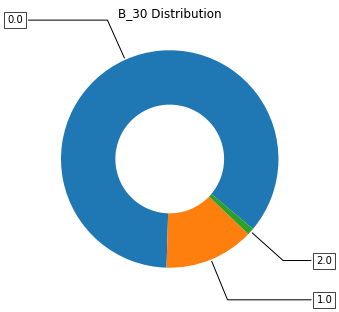

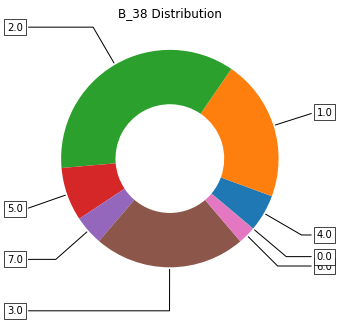

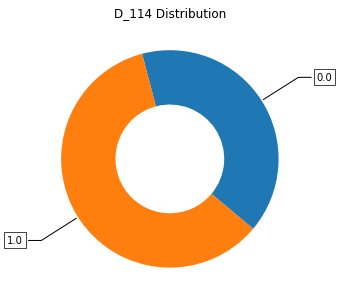

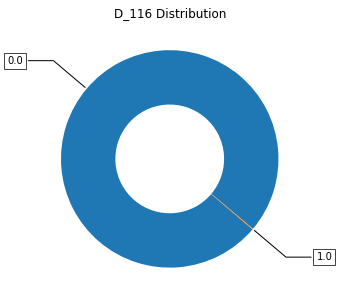

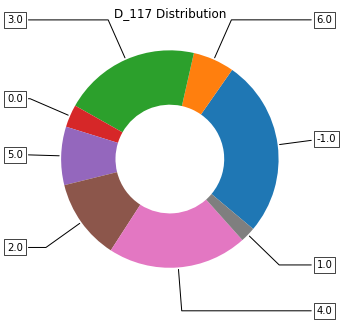

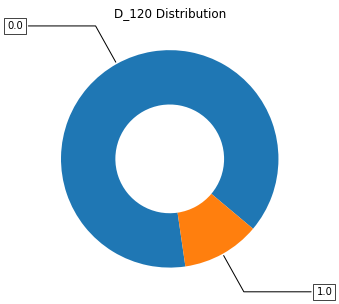

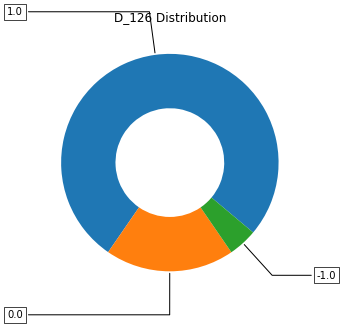

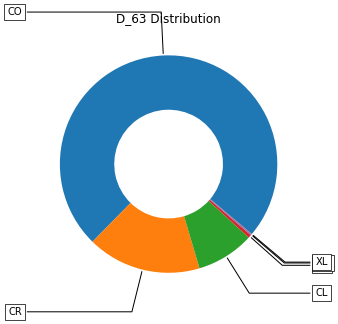

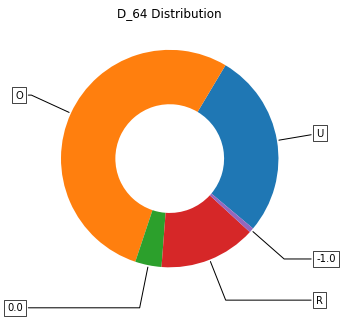

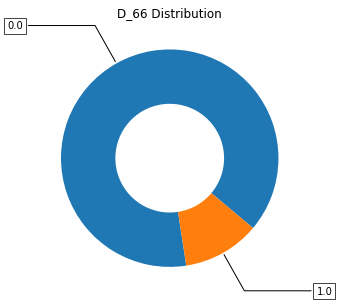

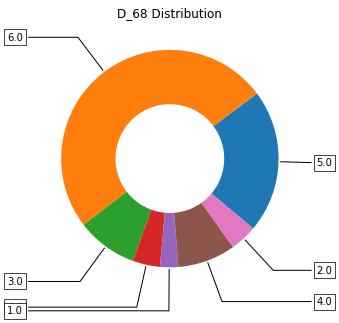

In [25]:
# input from American Express challenge
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

get_df_categories = df.select(categorical_variables).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()

for var in categorical_variables:
    var_collect = [x[var] for x in get_df_categories]
    counter = Counter(var_collect)
    plot_donut(var, counter)

In [26]:
df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- S_2: string (nullable = true)
 |-- P_2: double (nullable = true)
 |-- D_39: double (nullable = true)
 |-- B_1: double (nullable = true)
 |-- B_2: double (nullable = true)
 |-- R_1: double (nullable = true)
 |-- S_3: double (nullable = true)
 |-- D_41: double (nullable = true)
 |-- B_3: double (nullable = true)
 |-- D_42: double (nullable = true)
 |-- D_43: double (nullable = true)
 |-- D_44: double (nullable = true)
 |-- B_4: double (nullable = true)
 |-- D_45: double (nullable = true)
 |-- B_5: double (nullable = true)
 |-- R_2: double (nullable = true)
 |-- D_46: double (nullable = true)
 |-- D_47: double (nullable = true)
 |-- D_48: double (nullable = true)
 |-- D_49: double (nullable = true)
 |-- B_6: double (nullable = true)
 |-- B_7: double (nullable = true)
 |-- B_8: double (nullable = true)
 |-- D_50: double (nullable = true)
 |-- D_51: double (nullable = true)
 |-- B_9: double (nullable = true)
 |-- R_3: double (nullable = t

In [27]:
categorical_df = df.select(categorical_variables)
categorical_df.show(5)

+----+----+-----+-----+-----+-----+-----+----+----+----+----+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
| 0.0| 2.0|  0.0|  0.0|  3.0|  1.0|  1.0|  CO|   U| 0.0| 4.0|
| 0.0| 3.0|  1.0|  0.0| -1.0|  0.0|  1.0|  CR|   R| 0.0| 2.0|
| 0.0| 3.0|  1.0|  0.0|  3.0|  0.0|  1.0|  CR|   U| 0.0| 2.0|
| 0.0| 2.0|  1.0|  0.0|  2.0|  0.0|  1.0|  CL|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  2.0|  0.0|  1.0|  CL|   O| 0.0| 6.0|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
only showing top 5 rows



In [28]:
categorical_df.describe().show()

+-------+-------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------+--------------------+-------------------+------------------+
|summary|               B_30|              B_38|             D_114|               D_116|             D_117|              D_120|             D_126|  D_63|                D_64|               D_66|              D_68|
+-------+-------------------+------------------+------------------+--------------------+------------------+-------------------+------------------+------+--------------------+-------------------+------------------+
|  count|             552289|            552289|            552289|              552289|            552289|             552289|            552289|552289|              552289|             552289|            552289|
|   mean|0.15865787658273114|2.7179719313620225|0.5993800347281948|0.001249345904046...|2.2408901861163266|0.11325954346365762|0.723615715685085

In [29]:
categorical_df.describe().filter("summary = 'max'").collect()

[Row(summary='max', B_30='2.0', B_38='7.0', D_114='1.0', D_116='1.0', D_117='6.0', D_120='1.0', D_126='1.0', D_63='XZ', D_64='U', D_66='1.0', D_68='6.0')]

In [30]:
categorical_df.describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='-1.0', D_120='0.0', D_126='-1.0', D_63='CL', D_64='-1.0', D_66='0.0', D_68='0.0')]

D_117 and D_126 may be a problem as they were known values but we changed the nan values to 0, they have negative values I'll make them 0.5 to adjust to a category semantically closer to the original one

## Fixing the negative values appearing in the categories

In [31]:
for i in ['D_117', 'D_126', 'D_64']:
    df = df.withColumn(i, when((col(i) == -1.0), 0.5).otherwise(col(i)))

df.select(categorical_variables).describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='0.0', D_120='0.0', D_126='0.0', D_63='CL', D_64='0.0', D_66='0.0', D_68='0.0')]

## Casting string-type categories to numeric
As per the request of Spark

In [32]:
new_categorical_variables = [f'{col}_numeric' for col in categorical_variables]
indexer = StringIndexer(inputCols=categorical_variables, outputCols=new_categorical_variables).fit(df)
df = indexer.transform(df)

In [33]:
categorical_df = df.select(categorical_variables+new_categorical_variables)

In [34]:
categorical_df.groupby(['B_38_numeric', 'B_38']).count().show(5)

+------------+----+------+
|B_38_numeric|B_38| count|
+------------+----+------+
|         3.0| 5.0| 44289|
|         6.0| 6.0| 16372|
|         4.0| 4.0| 29921|
|         7.0| 0.0|   198|
|         2.0| 1.0|116053|
+------------+----+------+
only showing top 5 rows



In [35]:
categorical_df.groupby(['D_63_numeric', 'D_63']).count().show()

+------------+----+------+
|D_63_numeric|D_63| count|
+------------+----+------+
|         3.0|  XZ|  2611|
|         5.0|  XL|   661|
|         4.0|  XM|  1038|
|         0.0|  CO|411835|
|         2.0|  CL| 43521|
|         1.0|  CR| 92623|
+------------+----+------+



In [36]:
# somewhat a heavy operation (it could be avoided) but I prefer to keep the original category labels
reverse_dictionary = {col : dict(categorical_df.groupby([f'{col}_numeric', col]).count()\
                                 .drop('count').collect()) for col in categorical_variables}

reverse_dictionary['D_63']

{3.0: 'XZ', 5.0: 'XL', 4.0: 'XM', 0.0: 'CO', 2.0: 'CL', 1.0: 'CR'}

In [37]:
reverse_dictionary.keys()

dict_keys(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])

In [38]:
# dropping old columns from dataframe
df = df.drop(*categorical_variables)

## One hot encoding Categorical variables

In [39]:
output_col_names = [f'{col}_enc' for col in categorical_variables]
encoder = OneHotEncoder(inputCols = new_categorical_variables, 
                        outputCols = output_col_names)

model = encoder.fit(df)
df = model.transform(df)

# dropping the numeric columns from df
df = df.drop(*new_categorical_variables)

df.select(output_col_names).show(5)

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     B_30_enc|     B_38_enc|    D_114_enc|    D_116_enc|    D_117_enc|    D_120_enc|    D_126_enc|     D_63_enc|     D_64_enc|     D_66_enc|     D_68_enc|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(2,[0],[1.0])|(7,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(7,[1],[1.0])|    (1,[],[])|(2,[0],[1.0])|(5,[0],[1.0])|(4,[1],[1.0])|(1,[0],[1.0])|(6,[3],[1.0])|
|(2,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[2],[1.0])|(1,[0],[1.0])|(6,[5],[1.0])|
|(2,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[1],[1.0])|(1,[0],[1.0])|(6,[5],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[3],

In [40]:
# renaming back columns to original names
for encoded_name, original_name in zip(output_col_names, categorical_variables):
    df = df.withColumnRenamed(encoded_name, original_name)

## Getting the Labels to Join them

In [41]:
label_df = labels.toDF()
label_cols = label_df.columns
for label_wrong_col, label_correct_col in zip(label_cols, header_labels):
    label_df = label_df.withColumnRenamed(label_wrong_col, label_correct_col)
label_df.show(5)

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|   0.0|
|00000fd6641609c6e...|   0.0|
|00001b22f846c82c5...|   0.0|
|000041bdba6ecadd8...|   0.0|
|00007889e4fcd2614...|   0.0|
+--------------------+------+
only showing top 5 rows



In [42]:
df = df.join(label_df, ['customer_ID'])

In [43]:
columns_final = ['customer_ID', 'S_2', 'target']
feature_to_assemble = [col for col in header_features if col not in columns_final]

vecAssembler = VectorAssembler(inputCols=feature_to_assemble, 
                               outputCol="features")

assembled_df = vecAssembler.transform(df).select(columns_final+['features'])

In [44]:
assembled_df.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|000201146e53cacdd...|2017-06-30|   0.0|[0.948,0.12,0.194...|
|000473eb907b57c8c...|2017-12-08|   1.0|[0.498,0.029,0.69...|
|00050d84c6d26e26c...|2017-08-25|   0.0|[0.937,0.208,0.03...|
|00055add5eaee481b...|2017-03-17|   0.0|[0.841,0.002,0.00...|
|00055add5eaee481b...|2017-07-12|   0.0|[0.834,0.002,0.01...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [45]:
assembled_df.select('target').distinct().collect()

[Row(target=0.0), Row(target=1.0)]

In [46]:
distinct_values_per_category = {k : vector.__len__() for k, vector in df.select(categorical_variables).take(1)[0].asDict().items()}

In [47]:
distinct_values_per_category

{'B_30': 2,
 'B_38': 7,
 'D_114': 1,
 'D_116': 1,
 'D_117': 7,
 'D_120': 1,
 'D_126': 2,
 'D_63': 5,
 'D_64': 4,
 'D_66': 1,
 'D_68': 6}

In [48]:
# building the correct feature list (bc one hot encoding depacking was needed)

correct_col_list = list()

for col in feature_to_assemble:
    col_repeat = distinct_values_per_category.get(col, 1)
    for n in range(1, col_repeat+1):
        correct_col_list.append(col+'_'+str(n) if n > 1 else col)

In [49]:
# sampling the dataset before plotting
sample_assembled = assembled_df.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).select(['target', 'features'])

collected_assembled = sample_assembled.toPandas()
labels_collected = collected_assembled['target'] # extract target variable

# making a densevector if it is sparse and then expanding the vector into multiple columns
collected_assembled = collected_assembled.apply(lambda x: DenseVector(x["features"]), result_type="expand", axis=1)
collected_assembled.columns = correct_col_list
collected_assembled['target'] = labels_collected

In [50]:
collected_assembled.head()

P_2   D_39    B_1    B_2    R_1    S_3   D_41    B_3   D_42   D_43  ...  \
0  0.422  0.000  0.042  1.000  0.257  0.131  0.007  0.000  0.630  1.805  ...   
1  0.890  0.065  0.011  1.008  0.004  0.138  0.008  0.013  0.000  0.020  ...   
2  0.710  0.002  0.009  0.819  0.006  0.000  0.002  0.008  0.000  0.248  ...   
3  0.674  0.001  0.004  0.811  0.004  0.000  0.009  0.002  0.048  0.359  ...   
4  0.483  0.003  0.139  0.058  0.006  0.159  0.003  0.137  0.000  0.000  ...   

   D_137  D_138  D_139  D_140  D_141  D_142  D_143  D_144  D_145  target  
0  0.008  0.005  1.009  1.008  0.912  0.236  1.004  0.006  0.091     1.0  
1  0.000  0.000  0.004  0.009  0.000  0.000  0.005  0.003  0.008     0.0  
2  0.000  0.000  0.001  0.007  0.002  0.000  0.003  0.002  0.009     0.0  
3  0.000  0.000  0.009  0.006  0.000  0.000  0.005  0.001  0.005     1.0  
4  0.000  0.000  1.003  0.007  0.966  0.500  1.002  0.543  0.099     1.0  

[5 rows x 215 columns]

In [51]:
d_cols = [col for col in feature_to_assemble+['target'] if col[0].lower() == "d" or col == 'target']

In [52]:
collected_assembled[d_cols].head()

D_39   D_41   D_42   D_43   D_44   D_45   D_46   D_47   D_48   D_49  ...  \
0  0.000  0.007  0.630  1.805  0.009  0.010  0.481  0.079  0.148  0.000  ...   
1  0.065  0.008  0.000  0.020  0.004  0.379  0.537  0.507  0.172  0.000  ...   
2  0.002  0.002  0.000  0.248  0.005  0.311  0.000  0.393  0.000  0.000  ...   
3  0.001  0.009  0.048  0.359  0.009  0.015  0.472  0.370  0.307  0.000  ...   
4  0.003  0.003  0.000  0.000  0.004  0.028  0.499  0.368  0.562  0.343  ...   

   D_137  D_138  D_139  D_140  D_141  D_142  D_143  D_144  D_145  target  
0  0.008  0.005  1.009  1.008  0.912  0.236  1.004  0.006  0.091     1.0  
1  0.000  0.000  0.004  0.009  0.000  0.000  0.005  0.003  0.008     0.0  
2  0.000  0.000  0.001  0.007  0.002  0.000  0.003  0.002  0.009     0.0  
3  0.000  0.000  0.009  0.006  0.000  0.000  0.005  0.001  0.005     1.0  
4  0.000  0.000  1.003  0.007  0.966  0.500  1.002  0.543  0.099     1.0  

[5 rows x 97 columns]

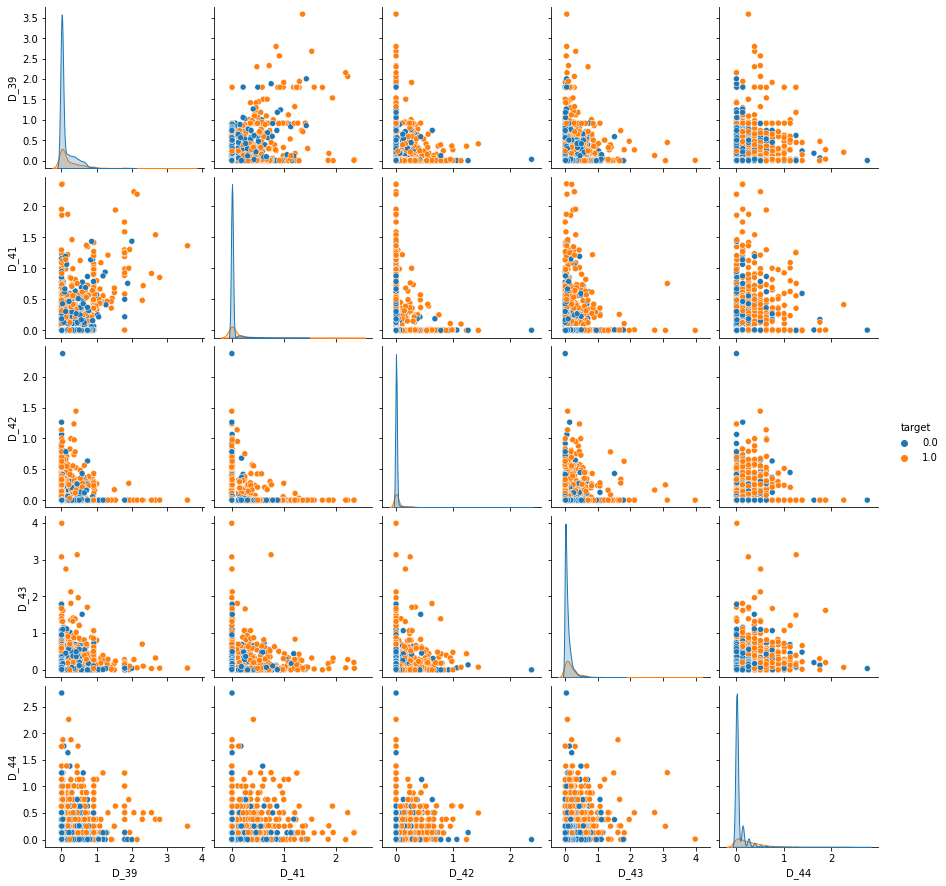

In [53]:
sns.pairplot(data = collected_assembled[d_cols[:5]+['target']], hue = 'target')
plt.show()

# Some visualizations of relashionships between variables

From a visualization point of view, we focused on relationship between some different type of variables in order to have a more clear perspective of how these variables are related between them.

In [54]:
vals = list(collected_assembled['target'].unique())
vals

[1.0, 0.0]

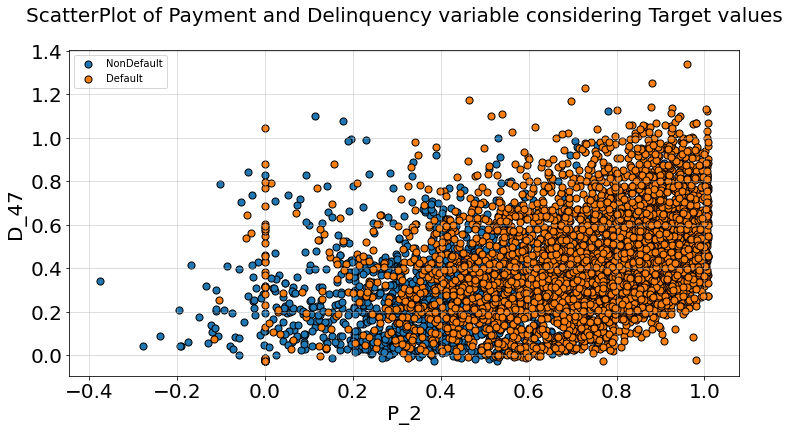

In [55]:
x = 'P_2'
y = 'D_47'

plt.figure(figsize=(12,6))
for val in vals:
    df_val = collected_assembled[collected_assembled['target']==val]
    plt.scatter(df_val[x], df_val[y], s=50, edgecolor='black', label=val)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel(x, fontsize=20)
plt.ylabel(y, fontsize=20)

plt.grid(alpha=0.5)
plt.legend(['NonDefault', 'Default'],  loc='best')
plt.title('ScatterPlot of Payment and Delinquency variable considering Target values\n', fontsize=20)
plt.show()

From this scatterplot, we can suppose that, with a lower value of P_2 (it can represent the payment amount of a customer), we have a dense cluster point of NonDefault customers related to a higher value of delinquency. In other words, if a customer is represented by an higher value of deliquency it doesn't mean that this client will default but instead, in contrast we see that customers with lower values of deliquency are those that are more inclined to Default.

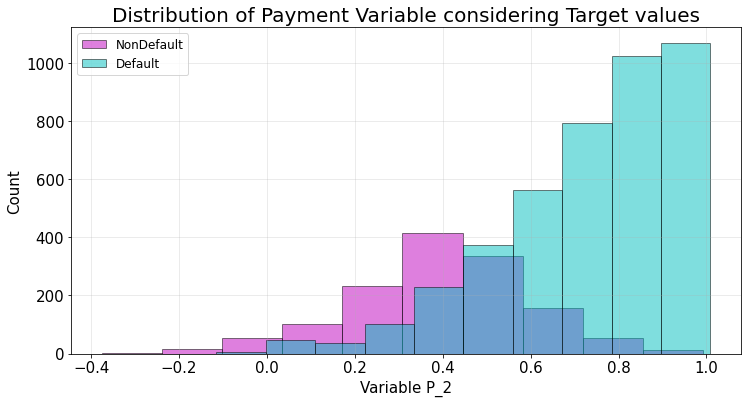

In [56]:
colors = ['m', 'c']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals):
    plt.hist( collected_assembled[ collected_assembled['target']==val ]['P_2'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(['NonDefault','Default'],loc='best', fontsize=12)
plt.xticks(fontsize=15)
plt.xlabel('Variable P_2', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of Payment Variable considering Target values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

Here, considering always the Payment Variable P_2 distribution, we confirm what it is said before, i.e. we have more probability of encounter persons that will Default with a medium/lower amount of payment in opposite to who tends to NonDefault with a higher amount of payment.

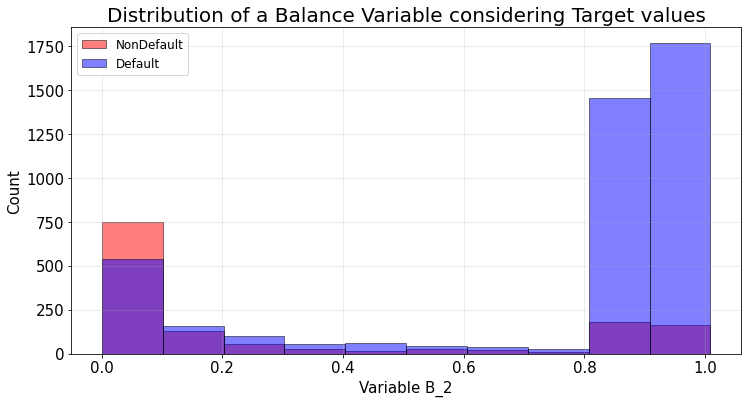

In [57]:
colors = ['r', 'b']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals):
    plt.hist( collected_assembled[ collected_assembled['target']==val ]['B_2'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(['NonDefault','Default'],loc='best', fontsize=12)
plt.xticks(fontsize=15)
plt.xlabel('Variable B_2', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of a Balance Variable considering Target values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

In this case we consider the distribution of a Balance Variable (here B_2) with the related Target values (always default and not default), we observe that customers that have a low Balance tend to Default more in respect to those that have a high Balance.

In [58]:
vals2 = list(collected_assembled['D_63'].unique())
vals2

[0.0, 1.0]

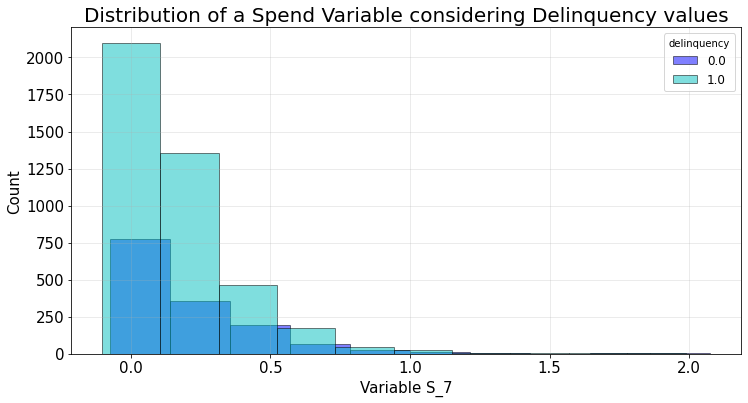

In [59]:
colors = ['b', 'c']
plt.figure(figsize=(12,6))
for i, val in enumerate(vals2):
    plt.hist( collected_assembled[ collected_assembled['D_63']==val ]['S_7'], color= colors[i],
             edgecolor='black', label=val, alpha=0.5)
    
plt.legend(loc='best', fontsize=12,title='delinquency')
plt.xticks(fontsize=15)
plt.xlabel('Variable S_7', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of a Spend Variable considering Delinquency values', fontsize=20)
plt.grid(alpha=0.3)
plt.show()

Here, considering the distribution of the S_7 Spend Variable and taking into account, in this case, the deliquency values taken from variable D_63, we see that we have, with lower values of Spend, more or less the same trend both for delinquency and not delinquency but, in general, there's a majority of people with higher delinquency in that first zone of Spend.

## Reducing Dimensionality to Measure Relations among Variables

In [60]:
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

In [61]:
# for only non categorical variables, extract a dictionary with "type of variable" : "list of variables"

distinct_vars = {var: list() for var in ["d", "s", "p", "b", "r"]}

for col in sorted(df.columns)[:-2]:
    if col not in categorical_variables + ["S_2"]:
        initial = col[0].lower()
        distinct_vars[initial].append(col)

print(distinct_vars)

{'d': ['D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'D_108', 'D_109', 'D_110', 'D_111', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128', 'D_129', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96'], 's': ['S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9'], 'p': ['P_2', 'P_3', 'P_4'], 'b': ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15',

Now reducing dimensionality by making the mean of all the columns of the same kind of variable... 

It is a non standard reduction method that implies a sort of similarity in the meaning of each variable

In [62]:
df_grouped = df.select('*', ( sum(df[col] for col in distinct_vars["d"]) / len(distinct_vars["d"])).alias('avg_d'),
                            ( sum(df[col] for col in distinct_vars["s"]) / len(distinct_vars["s"])).alias('avg_s'),
                            ( sum(df[col] for col in distinct_vars["p"]) / len(distinct_vars["p"])).alias('avg_p'),
                            ( sum(df[col] for col in distinct_vars["b"]) / len(distinct_vars["b"])).alias('avg_b'),
                            ( sum(df[col] for col in distinct_vars["r"]) / len(distinct_vars["r"])).alias('avg_r')
                        )

avg_col_list = ["avg_" + col for col in list(distinct_vars.keys())]
df_grouped = df_grouped.select(avg_col_list+['target'])
df_grouped.show(5)

+-------------------+-------------------+-------------------+-------------------+-------------------+------+
|              avg_d|              avg_s|              avg_p|              avg_b|              avg_r|target|
+-------------------+-------------------+-------------------+-------------------+-------------------+------+
|0.18902298850574714| 0.2728095238095238| 0.6106666666666666|0.21163157894736837|0.07985714285714281|   0.0|
| 0.2323563218390805|0.22276190476190477|0.32133333333333336|0.36086842105263156|0.13257142857142853|   1.0|
|0.15821839080459774|0.24347619047619048|              0.524|0.13447368421052627| 0.0758571428571428|   0.0|
|0.07127586206896552|0.13314285714285712| 0.5053333333333333|0.12257894736842107|0.07553571428571425|   0.0|
|0.07320689655172412|0.24514285714285713| 0.4943333333333333|0.12326315789473682|0.07474999999999998|   0.0|
+-------------------+-------------------+-------------------+-------------------+-------------------+------+
only showing top 5 

Scaling the averages obtained with a minmax scaler

In [63]:
df_grouped.take(1)

[Row(avg_d=0.18902298850574714, avg_s=0.2728095238095238, avg_p=0.6106666666666666, avg_b=0.21163157894736837, avg_r=0.07985714285714281, target=0.0)]

In [64]:
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType()) # rounding to t

for col in avg_col_list:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[col], outputCol=col+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=col+"_Vect", outputCol=col+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe (adding scaled columns and dropping unscaled one)
    df_grouped = pipeline.fit(df_grouped).transform(df_grouped).withColumn(f"{col}_Scaled", unlist(f"{col}_Scaled")).drop(f"{col}_Vect")

In [65]:
df_grouped_to_show  = df_grouped.select([f"{col}_Scaled" for col in avg_col_list] + ["target"])

In [66]:
df_grouped_to_show.show(5)

+------------+------------+------------+------------+------------+------+
|avg_d_Scaled|avg_s_Scaled|avg_p_Scaled|avg_b_Scaled|avg_r_Scaled|target|
+------------+------------+------------+------------+------------+------+
|       0.001|       0.517|       0.618|       0.002|       0.001|   0.0|
|       0.002|       0.515|        0.45|       0.003|       0.002|   1.0|
|       0.001|       0.516|       0.568|       0.001|       0.001|   0.0|
|         0.0|       0.512|       0.557|       0.001|       0.001|   0.0|
|         0.0|       0.516|        0.55|       0.001|       0.001|   0.0|
+------------+------------+------------+------------+------------+------+
only showing top 5 rows



In [67]:
parirplot_df = df_grouped_to_show.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).toPandas()

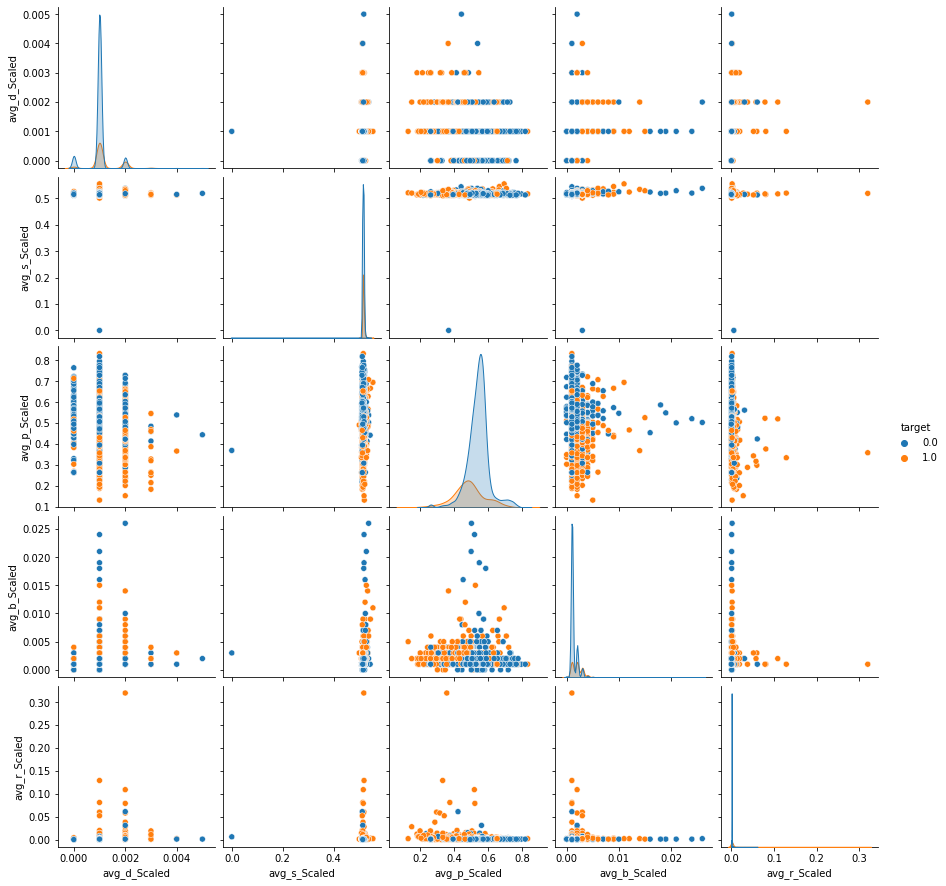

In [68]:
sns.pairplot(parirplot_df, hue= "target")

# Feature Selections

In this section we will explore different classifiers using, as Feature selection, the Variance Threshold method.

## Feature Selection with Variance Threshold

In [69]:
selector_variance = VarianceThresholdSelector(varianceThreshold=0.5, outputCol="selectedFeatures")
model_variance = selector_variance.fit(assembled_df)

print(f"Selected features: {model_variance.selectedFeatures}")

Selected features: [19, 28, 36, 76, 77, 90, 93, 98, 110, 141, 143, 169]


In [70]:
feature_selected = [e for i,e in enumerate(df.columns) if i in model_variance.selectedFeatures]
print('Features chosen from Variance Threshold: {}'.format(feature_selected))

Features chosen from Variance Threshold: ['D_48', 'D_52', 'R_4', 'R_7', 'D_77', 'D_82', 'B_28', 'D_84', 'B_32', 'D_109', 'D_111', 'D_136']


As seen above, the variables a highest variance considering the 0.5 variance threshold are those related to Delinquency category.

In [71]:
columns_to_add = ['customer_ID', 'S_2', 'target']

new = model_variance.transform(assembled_df).select(columns_to_add + ['selectedFeatures'])
new.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|    selectedFeatures|
+--------------------+----------+------+--------------------+
|000201146e53cacdd...|2017-06-30|   0.0|[0.053,0.018,0.02...|
|000473eb907b57c8c...|2017-12-08|   1.0|[0.007,0.012,0.01...|
|00050d84c6d26e26c...|2017-08-25|   0.0|[0.198,0.295,0.07...|
|00055add5eaee481b...|2017-03-17|   0.0|[0.179,0.293,0.01...|
|00055add5eaee481b...|2017-07-12|   0.0|[0.218,0.301,0.00...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



Taking 0.5 as variance Threshold, we found only 5 of the original 190 variables. On top of this, we will train different classifiers to see their perfomances.

In [72]:
#Initializing varianceT dict to collect results
varianceT_metrics_dict = dict()

### Random forest

In [73]:
train, validation = new.randomSplit(weights=[0.8,0.2], seed=42)

In [74]:
rf = RandomForestClassifier(labelCol="target", featuresCol="selectedFeatures", seed=42, numTrees=30)
model_rf = rf.fit(train)

In [75]:
predictions = model_rf.transform(validation)

In [76]:
rf_varianceT_metrics = compute_metrics()
rf_varianceT_metrics

{'f1': 0.8104381105211355,
 'accuracy': 0.8178083803078148,
 'recallByLabel': 0.5298766877675729,
 'precisionByLabel': 0.6652119987137672}

In [77]:
ytest, ypred = get_ytest_ypred()
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       873
         1.0       0.65      0.55      0.59       254

    accuracy                           0.83      1127
   macro avg       0.76      0.73      0.74      1127
weighted avg       0.82      0.83      0.83      1127



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


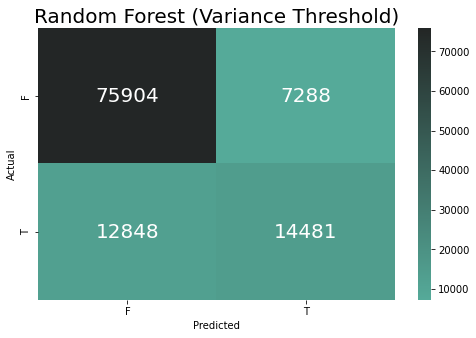

In [78]:
plot_conf_matrix(sns.color_palette("dark:#5A9_r", as_cmap=True), title = 'Random Forest (Variance Threshold)')

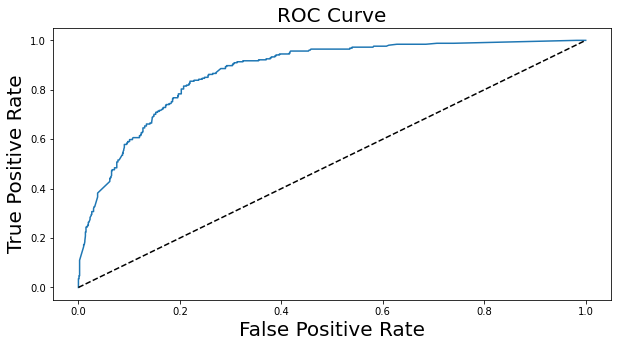

In [79]:
plot_roc_curve()

### Decision Tree

In [80]:
# training
model_dt_v = DecisionTreeClassifier(featuresCol="selectedFeatures", labelCol="target")
model_dt_v = model_dt_v.fit(train)
# predictions
predictions = model_dt_v.transform(validation)

In [81]:
dt_varianceT_matrics = compute_metrics()
dt_varianceT_matrics

{'f1': 0.8110798292020378,
 'accuracy': 0.8105337447181984,
 'recallByLabel': 0.6255991803578617,
 'precisionByLabel': 0.6148894083797878}

In [82]:
ytest, ypred = get_ytest_ypred()
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88       873
         1.0       0.57      0.62      0.59       254

    accuracy                           0.81      1127
   macro avg       0.73      0.74      0.73      1127
weighted avg       0.82      0.81      0.81      1127



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


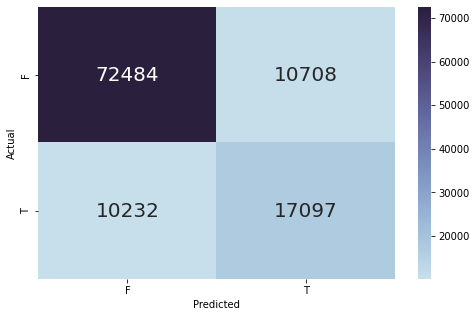

In [83]:
plot_conf_matrix(sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True))

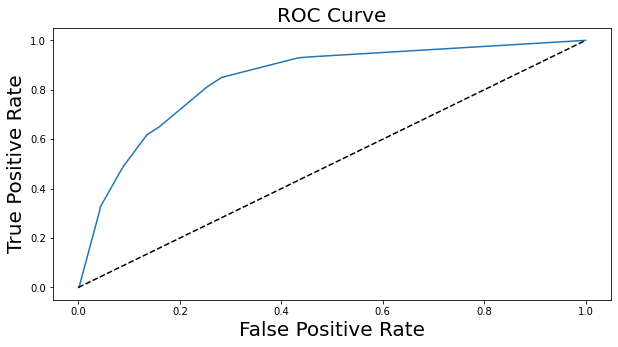

In [84]:
plot_roc_curve()

### GBTClassifier

In [85]:
gbtc = GBTClassifier(featuresCol = 'selectedFeatures', labelCol="target", maxIter=20)
gbtc = gbtc.fit(train)
# prediction
predictions = gbtc.transform(validation)

In [86]:
gbt_varianceT_metrics = compute_metrics()
gbt_varianceT_metrics

{'f1': 0.817173131013379,
 'accuracy': 0.8217985722170448,
 'recallByLabel': 0.5707124300193933,
 'precisionByLabel': 0.6620118845500849}

In [87]:
ytest, ypred = get_ytest_ypred()
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89       873
         1.0       0.62      0.59      0.61       254

    accuracy                           0.83      1127
   macro avg       0.75      0.74      0.75      1127
weighted avg       0.82      0.83      0.83      1127



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


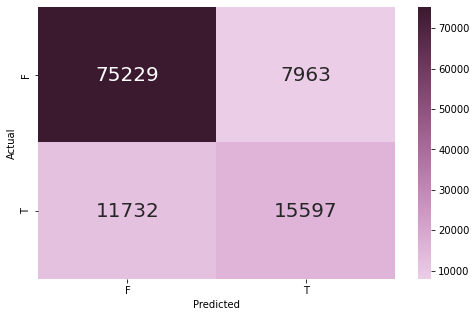

In [88]:
plot_conf_matrix(sns.color_palette("ch:start=.6,rot=-.05", as_cmap=True))

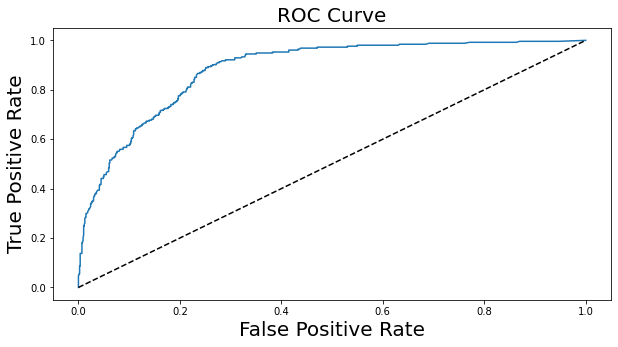

In [89]:
plot_roc_curve()

### SVM

Here we performed a Gridsearch with spark as we tryed to get the best performances

In [90]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [91]:
#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

In [92]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train)

In [93]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.7513892489601768, 10),
 (0.7516710438811051, 1),
 (0.7546355264492712, 0.1),
 (0.757137865347115, 0.01),
 (0.7565855473020954, 0.001),
 (0.7580508808909229, 0.0001)]

In [94]:
# Make predictions on test data. 
predictions = model_tvs.transform(validation)
    
# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions) 

# Show the accuracy
print(f"Test accuracy = {accuracy:.5f}")

Test accuracy = 0.75880


In [95]:
svm_varianceT_metrics = compute_metrics(labelCol="label")
svm_varianceT_metrics

{'f1': 0.6644146152475252,
 'accuracy': 0.7587969707114485,
 'recallByLabel': 0.03351750887335797,
 'precisionByLabel': 0.788975021533161}

In all the cases, performances are similar except in case of linear SVC. In trees classifiers, Recall and F1-score for Credit Default are never high but don't tend to 0 as for SVC. Even changing the max_iter parameter, Recall and F1score for Credit Default tend always to 0, supposing that a linear boundary is not the best case for distinguish the Credit Default. A non-linear SVC would have suited the case better but unfortunately it is not yet present in PySpark.

In [96]:
#Uploading results to variance treshold dict
varianceT_metrics_dict.update({"dt": dt_varianceT_matrics,
                               "rf": rf_varianceT_metrics,
                               "gbt": gbt_varianceT_metrics,
                               "svm": svm_varianceT_metrics})

varianceT_metrics_dict

{'dt': {'f1': 0.8110798292020378,
  'accuracy': 0.8105337447181984,
  'recallByLabel': 0.6255991803578617,
  'precisionByLabel': 0.6148894083797878},
 'rf': {'f1': 0.8104381105211355,
  'accuracy': 0.8178083803078148,
  'recallByLabel': 0.5298766877675729,
  'precisionByLabel': 0.6652119987137672},
 'gbt': {'f1': 0.817173131013379,
  'accuracy': 0.8217985722170448,
  'recallByLabel': 0.5707124300193933,
  'precisionByLabel': 0.6620118845500849},
 'svm': {'f1': 0.6644146152475252,
  'accuracy': 0.7587969707114485,
  'recallByLabel': 0.03351750887335797,
  'precisionByLabel': 0.788975021533161}}

## Feature Selection Univariate

These will be the features we will use from now on

In [97]:
# ChiSqSelector - Deprecated since version 3.1.0: Thus UnivariateFeatureSelector

selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="target", selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

columns_final.append('selectedFeatures')

fitting = selector.fit(assembled_df)
selected_feat = fitting.selectedFeatures

result = fitting.transform(assembled_df).select(columns_final)

print(f"UnivariateFeatureSelector output with top {selector.getSelectionThreshold()} features selected using f_classif")

UnivariateFeatureSelector output with top 20.0 features selected using f_classif


In [98]:
result.take(1)

[Row(customer_ID='000201146e53cacdde1c7e9d29f4d3c46fd4d9231a3744aa39fb9c6afa79b708', S_2='2017-06-30', target=0.0, selectedFeatures=DenseVector([0.948, 0.12, 0.194, 0.027, 0.004, 0.124, 0.0, 0.695, 0.0, 0.257, 0.002, 0.143, 0.12, 0.007, 0.007, 0.237, 0.36, 0.079, 0.0, 0.053]))]

In [99]:
#selected explicit features
new_header = [col for col in df.columns if col not in columns_final]
sel_feat_expl = [new_header[n] for n in selected_feat]

In [100]:
print('Features Extracted: ')
print(*sel_feat_expl, sep = ', ')

Features Extracted: 
P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_42, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, D_49, B_6


## Plotting Original and Selected Features

Here the original features

In [101]:
# getting the distribution of the original type of variables
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

orig_cdist = Counter(re.findall('\w*_', ' '.join(new_header)))

print(orig_cdist)

Counter({'D_': 96, 'B_': 40, 'R_': 28, 'S_': 21, 'P_': 3})


Now the Selected features

In [102]:
selected_cdist = Counter(re.findall('\w*_', ' '.join(sel_feat_expl)))

print(selected_cdist)

Counter({'D_': 10, 'B_': 6, 'R_': 2, 'P_': 1, 'S_': 1})


It seems the most important variables keep the same distribution as the original one

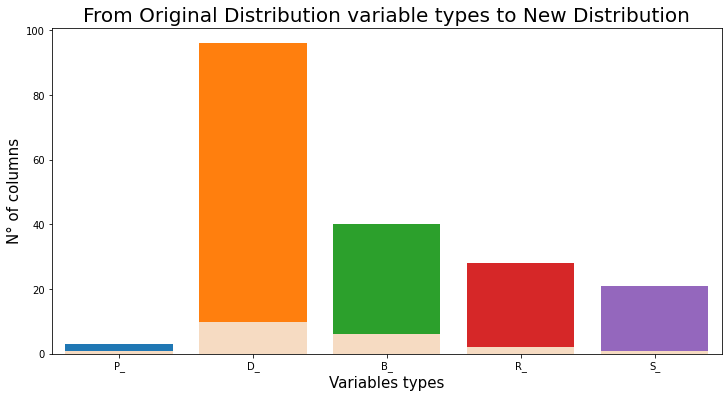

In [103]:
#Plotting Variables Original and New distribution
plt.figure(figsize=(12,6))
plt.ylabel("N° of columns", fontsize=15)
plt.xlabel("Variables types", fontsize=15)
plt.title('From Original Distribution variable types to New Distribution', fontsize=20)
sns.barplot(x=list(orig_cdist.keys()), y=list(orig_cdist.values()), saturation=1)
sns.barplot(x=list(selected_cdist.keys()), y=list(selected_cdist.values()), color='peachpuff')
plt.show()

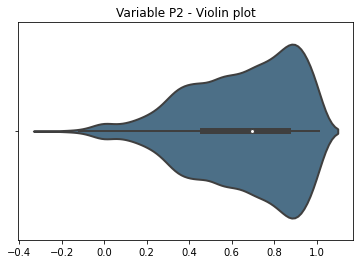

In [104]:
# again, we are working with a sample because we may in theory have many more records

p2_get = df.select("P_2").sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()
sns.violinplot(x=[row["P_2"] for row in p2_get], linewidth=2, saturation=0.4)
plt.title('Variable P2 - Violin plot')
plt.show()

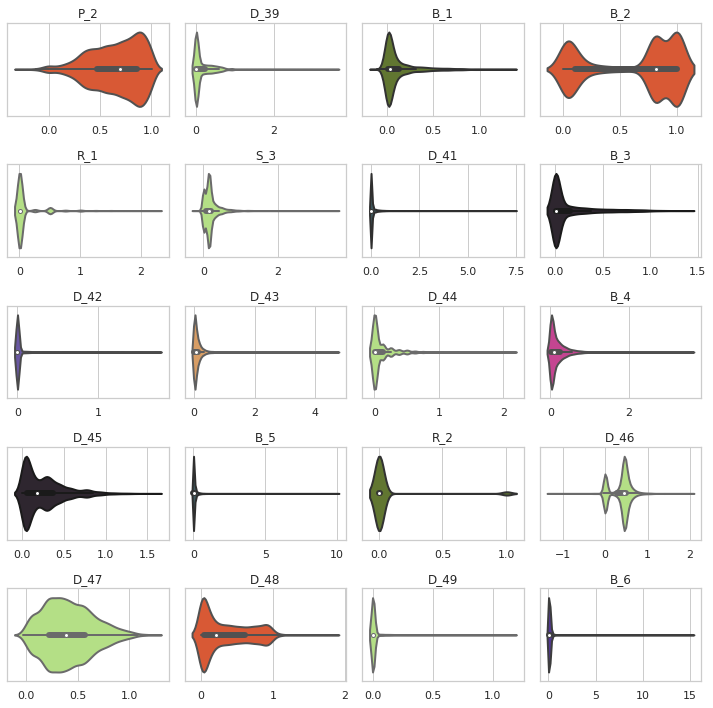

In [105]:
np.random.seed(0)
sns.set_theme(style="whitegrid")

number_of_colors = len(sel_feat_expl)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

cols = 4
rows = 5
fig = plt.figure(figsize= (10,10))

# again sampling before collecting
var_extracted = df.select(sel_feat_expl).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()

for i, col in enumerate(sel_feat_expl):
    
    ax = fig.add_subplot(rows, cols, i+1)
    
    sns.violinplot(x = [row[col] for row in var_extracted], ax=ax, color = random.choice(color), linewidth=2)

    plt.title(col)
    
fig.tight_layout()  
plt.show()

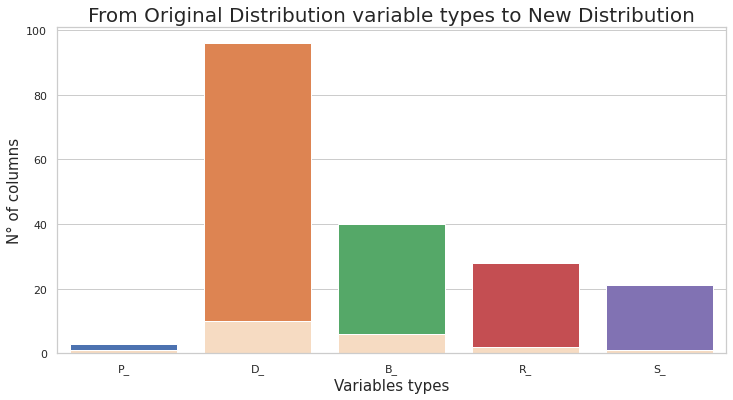

In [106]:
#Plotting Variables Original and New distribution
plt.figure(figsize=(12,6))
plt.ylabel("N° of columns", fontsize=15)
plt.xlabel("Variables types", fontsize=15)
plt.title('From Original Distribution variable types to New Distribution', fontsize=20)
sns.barplot(x=list(orig_cdist.keys()), y=list(orig_cdist.values()), saturation=1)
sns.barplot(x=list(selected_cdist.keys()), y=list(selected_cdist.values()), color='peachpuff')
plt.show()

Before starting with the classification part, let's look at which of the selected variables are the most correlated and which are the least.

In [107]:
# take the features from the Univariate Feature selection for plotting the matrix
dfcorr = df.select([e for e in df.columns if e in sel_feat_expl])

In [108]:
# need to convert in rdd to check correlationfrom pyspark.mllib.stat import Statistics
feature_regr = dfcorr.rdd.map(lambda x: x[0:])
correlation_mat = Statistics.corr(feature_regr, method='pearson')

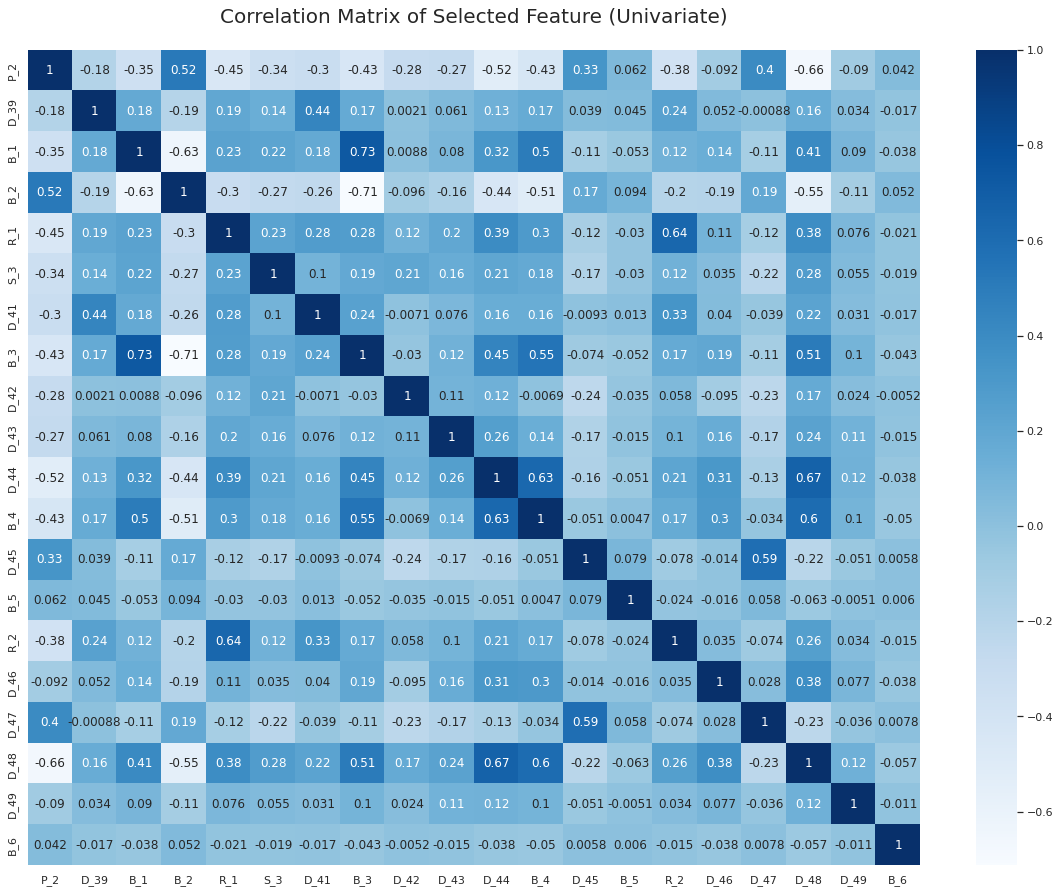

In [109]:
plt.figure(figsize=(20,15))
sns.heatmap(correlation_mat, xticklabels=[e for e in sel_feat_expl], yticklabels=[e for e in sel_feat_expl], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))
plt.title('Correlation Matrix of Selected Feature (Univariate)\n', fontsize=20)
plt.show()

In [110]:
#Initializing univariate feature selection metrics dict
univariate_metrics_dict = dict()

### Train-test split

In [111]:
train, validation = result.randomSplit(weights = [0.8, 0.2], seed = 42)

#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

### Decision Tree

In [112]:
# training
model_dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model_dt = model_dt.fit(train)
# predictions
predictions = model_dt.transform(validation)

In [113]:
dt_univariate_matrics = compute_metrics(labelCol="label")
dt_univariate_matrics

{'f1': 0.8505021166469485,
 'accuracy': 0.8495037142262556,
 'recallByLabel': 0.716125727249442,
 'precisionByLabel': 0.6880053434577796}

In [114]:
ytest, ypred = get_ytest_ypred(target_prediction = ['label', 'prediction'])
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.89       873
         1.0       0.63      0.70      0.66       254

    accuracy                           0.84      1127
   macro avg       0.77      0.79      0.78      1127
weighted avg       0.85      0.84      0.84      1127



### Random Forest

In [115]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42, numTrees=30)
model = rf.fit(train)

In [116]:
rf_feat_imp = model.featureImportances

In [117]:
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])

correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]
correct_feat_by_imp

[('P_2', 0.29976967263458215),
 ('B_6', 0.14865706556191433),
 ('B_4', 0.1148161407185082),
 ('B_2', 0.09340985724439341),
 ('S_3', 0.07278339387859797),
 ('D_42', 0.05289882379244084),
 ('B_5', 0.032048146481816704),
 ('D_43', 0.03076273616737248),
 ('D_45', 0.028207697091342385),
 ('D_41', 0.026316394881381832),
 ('R_1', 0.02365182142484361),
 ('D_48', 0.009061741310034918),
 ('D_44', 0.003743994290893999),
 ('R_2', 0.003049208039032),
 ('D_46', 0.0028536801482547725),
 ('B_3', 0.0018392360287104719),
 ('D_47', 0.0004904559632860862),
 ('B_1', 0.0)]

In [118]:
def plot_feature_importance(importance):

    import pandas as pd
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array([value for var, value in importance])
    feature_names = np.array([var for var,value in importance])

    #Create a DataFrame using a Dictionary
    data = {'feature_names' : feature_names,'feature_importance' : feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Feature Importances of RF',fontsize=18)
    plt.xlabel('Feature Importance',fontsize=12)
    plt.ylabel('Feature Names',fontsize=12)

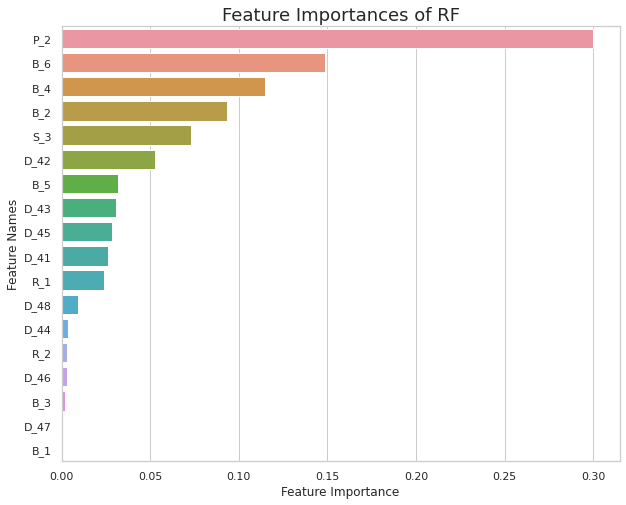

In [119]:
plot_feature_importance(correct_feat_by_imp)

In [120]:
predictions = model.transform(validation)

In [121]:
predictions.show(5)

+--------------------+----------+-----+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|label|            features|       rawPrediction|         probability|prediction|
+--------------------+----------+-----+--------------------+--------------------+--------------------+----------+
|00050d84c6d26e26c...|2017-08-25|  0.0|[0.937,0.208,0.03...|[28.9932153755336...|[0.96644051251778...|       0.0|
|000678921d09c5503...|2017-06-03|  0.0|[0.955,0.005,0.00...|[28.9932153755336...|[0.96644051251778...|       0.0|
|0008ef32824d3067b...|2017-06-12|  0.0|[0.866,0.007,0.00...|[28.3309970231094...|[0.94436656743698...|       0.0|
|000940eb997a3356d...|2017-12-02|  0.0|[0.913,0.0,0.079,...|[25.4202619549414...|[0.84734206516471...|       0.0|
|0013037420169086d...|2017-05-31|  0.0|[0.801,0.006,0.01...|[26.1965848707431...|[0.87321949569143...|       0.0|
+--------------------+----------+-----+--------------------+--------------------+-------

In [122]:
rf_univariate_metrics = compute_metrics(labelCol="label")

In [123]:
ytest, ypred = get_ytest_ypred(target_prediction = ['label', 'prediction'])
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       873
         1.0       0.69      0.70      0.70       254

    accuracy                           0.86      1127
   macro avg       0.80      0.81      0.80      1127
weighted avg       0.86      0.86      0.86      1127



### Gradient Boosted Tree 

GBTs iteratively train decision trees in order to minimize a loss function.

In [124]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(train)
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(train)

In [125]:
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=5)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

In [126]:
model = pipeline.fit(train)
predictions = model.transform(validation)

In [127]:
predictions.show(5)

+--------------------+----------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|label|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+--------------------+----------+-----+--------------------+------------+--------------------+--------------------+--------------------+----------+
|00050d84c6d26e26c...|2017-08-25|  0.0|[0.937,0.208,0.03...|         0.0|[0.937,0.208,0.03...|[1.14592143406414...|[0.90819921188183...|       0.0|
|000678921d09c5503...|2017-06-03|  0.0|[0.955,0.005,0.00...|         0.0|[0.955,0.005,0.00...|[1.14592143406414...|[0.90819921188183...|       0.0|
|0008ef32824d3067b...|2017-06-12|  0.0|[0.866,0.007,0.00...|         0.0|[0.866,0.007,0.00...|[1.13963845242099...|[0.90714615705552...|       0.0|
|000940eb997a3356d...|2017-12-02|  0.0|[0.913,0.0,0.079,...|         0.0|[0.913,0.0,0.079,...|[0.94384569802884.

In [128]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy:.4f} \nTest Error = {(1.0 - accuracy):.4f}")

Accuracy = 0.8541 
Test Error = 0.1459


In [129]:
gbt_univariate_results = compute_metrics(labelCol = 'label')

### SVM


In [130]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [131]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train)

In [132]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.7513892489601768, 10),
 (0.8362433355501201, 1),
 (0.8602071756258666, 0.1),
 (0.8625855247585017, 0.01),
 (0.8630251248351499, 0.001),
 (0.8629913094446385, 0.0001)]

In [133]:
# Make predictions on test data. 
predictions = model_tvs.transform(validation)
    
# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
accuracy = evaluator.evaluate(predictions) 

# Show the accuracy and test error
print(f"Accuracy = {accuracy:.4f} \nTest Error = {(1.0 - accuracy):.4f}")

Accuracy = 0.8631 
Test Error = 0.1369


In [134]:
svm_univariate_metrics = compute_metrics(labelCol = 'label')

In [135]:
#Uploading results to univariate dict
univariate_metrics_dict.update({"dt": dt_univariate_matrics,
                                "rf": rf_univariate_metrics,
                                "gbt": gbt_univariate_results,
                                "svm": svm_univariate_metrics})

univariate_metrics_dict

{'dt': {'f1': 0.8505021166469485,
  'accuracy': 0.8495037142262556,
  'recallByLabel': 0.716125727249442,
  'precisionByLabel': 0.6880053434577796},
 'rf': {'f1': 0.854155982171042,
  'accuracy': 0.8552130364365144,
  'recallByLabel': 0.6862307438984229,
  'precisionByLabel': 0.7163209961422405},
 'gbt': {'f1': 0.8553776889960765,
  'accuracy': 0.8540820296595217,
  'recallByLabel': 0.7326283435178748,
  'precisionByLabel': 0.6941959642188475},
 'svm': {'f1': 0.8618373109931291,
  'accuracy': 0.8630757955501669,
  'recallByLabel': 0.6973178674667935,
  'precisionByLabel': 0.7352805000385833}}

In [136]:
predictions

DataFrame[customer_ID: string, S_2: string, label: double, features: vector, rawPrediction: vector, prediction: double]

## Feature Selection Univariate - NO Outliers

### Removing Outliers

In [137]:
bounds = {col:dict(zip(["q1", "q3"], df.select(sel_feat_expl).approxQuantile(col, [0.25, 0.75], 0))) for col in sel_feat_expl}

In [138]:
for col in bounds:
    iqr = bounds[col]['q3'] - bounds[col]['q1']
    bounds[col]['min'] = bounds[col]['q1'] - (iqr * 1.5)
    bounds[col]['max'] = bounds[col]['q3'] + (iqr * 1.5)

print(bounds)

{'P_2': {'q1': 0.473, 'q3': 0.863, 'min': -0.11199999999999999, 'max': 1.448}, 'D_39': {'q1': 0.004, 'q3': 0.236, 'min': -0.344, 'max': 0.584}, 'B_1': {'q1': 0.008, 'q3': 0.126, 'min': -0.16899999999999998, 'max': 0.303}, 'B_2': {'q1': 0.104, 'q3': 1.002, 'min': -1.2429999999999999, 'max': 2.349}, 'R_1': {'q1': 0.002, 'q3': 0.008, 'min': -0.007000000000000001, 'max': 0.017}, 'S_3': {'q1': 0.078, 'q3': 0.212, 'min': -0.12300000000000001, 'max': 0.41300000000000003}, 'D_41': {'q1': 0.002, 'q3': 0.008, 'min': -0.007000000000000001, 'max': 0.017}, 'B_3': {'q1': 0.005, 'q3': 0.154, 'min': -0.21849999999999997, 'max': 0.37749999999999995}, 'D_42': {'q1': 0.0, 'q3': 0.0, 'min': 0.0, 'max': 0.0}, 'D_43': {'q1': 0.0, 'q3': 0.131, 'min': -0.1965, 'max': 0.3275}, 'D_44': {'q1': 0.003, 'q3': 0.131, 'min': -0.189, 'max': 0.323}, 'B_4': {'q1': 0.027, 'q3': 0.239, 'min': -0.291, 'max': 0.5569999999999999}, 'D_45': {'q1': 0.054, 'q3': 0.373, 'min': -0.42450000000000004, 'max': 0.8515}, 'B_5': {'q1': 0

In [139]:
#Adding columns saying if a record is an outlier w.r.t. the column itself

df_outliers = df.select("*", *[f.when( f.col(c).between(bounds[c]['min'], 
                                                        bounds[c]['max']), 0).otherwise(1).alias(c+"_out") for c in sel_feat_expl])

df_outliers.select([col+"_out" for col in sel_feat_expl]).show(5)

+-------+--------+-------+-------+-------+-------+--------+-------+--------+--------+--------+-------+--------+-------+-------+--------+--------+--------+--------+-------+
|P_2_out|D_39_out|B_1_out|B_2_out|R_1_out|S_3_out|D_41_out|B_3_out|D_42_out|D_43_out|D_44_out|B_4_out|D_45_out|B_5_out|R_2_out|D_46_out|D_47_out|D_48_out|D_49_out|B_6_out|
+-------+--------+-------+-------+-------+-------+--------+-------+--------+--------+--------+-------+--------+-------+-------+--------+--------+--------+--------+-------+
|      0|       0|      0|      0|      0|      0|       0|      1|       0|       0|       0|      0|       0|      0|      0|       0|       0|       0|       0|      0|
|      0|       0|      1|      0|      1|      0|       0|      1|       0|       0|       1|      0|       0|      0|      0|       0|       0|       0|       1|      0|
|      0|       0|      0|      0|      0|      0|       0|      0|       0|       0|       0|      0|       0|      0|      0|       0|    

In [140]:
#Dataframe with new Outlier column; 0 == No Outlier / 1 == Outlier
df_outliers = df_outliers.withColumn("outlier", sum(df_outliers[f"{col}_out"] for col in sel_feat_expl))
df_outliers.select(["customer_ID", "outlier"]).show(5)

+--------------------+-------+
|         customer_ID|outlier|
+--------------------+-------+
|000201146e53cacdd...|      1|
|000473eb907b57c8c...|      5|
|0004e00358fc4dd63...|      0|
|0004e00358fc4dd63...|      1|
|00050d84c6d26e26c...|      0|
+--------------------+-------+
only showing top 5 rows



In [141]:
#Dataframe with no outliers
df_no_outliers = df_outliers.where('outlier < 3')
print(f"No Outlier dataset count: {df_no_outliers.count()}")
df_no_outliers.select(["customer_ID", "outlier"]).show(5)

No Outlier dataset count: 431202
+--------------------+-------+
|         customer_ID|outlier|
+--------------------+-------+
|000201146e53cacdd...|      1|
|0004e00358fc4dd63...|      0|
|0004e00358fc4dd63...|      1|
|00050d84c6d26e26c...|      0|
|00055add5eaee481b...|      0|
+--------------------+-------+
only showing top 5 rows



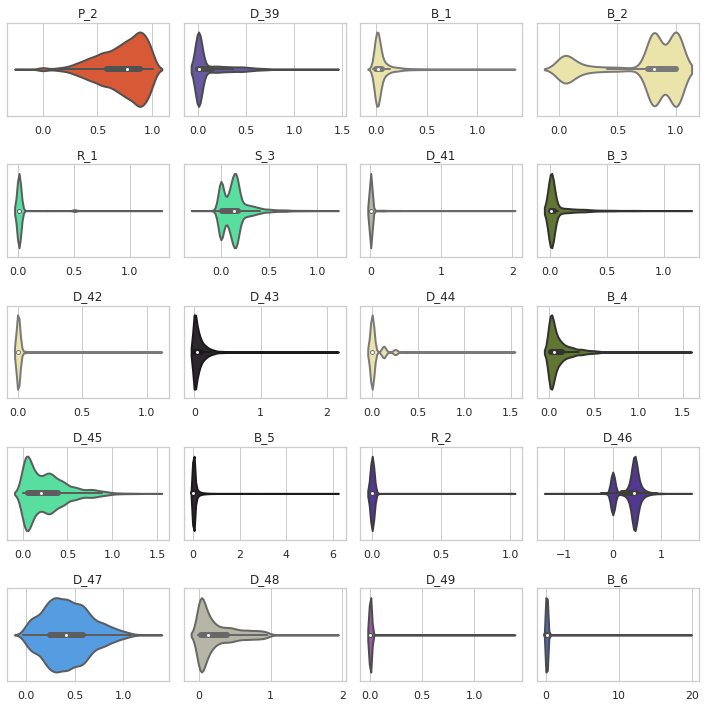

In [142]:
np.random.seed(0)
sns.set_theme(style="whitegrid")

cols = 4
rows = 5
fig = plt.figure(figsize= (10,10))

# again sampling before collecting
var_extracted = df_no_outliers.select(sel_feat_expl).sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42).collect()

for i, col in enumerate(sel_feat_expl):
    
    ax = fig.add_subplot(rows, cols, i+1)
    
    sns.violinplot(x=[row[col] for row in var_extracted], ax=ax, color = random.choice(color), linewidth=2)
    
    plt.title(col)
    
fig.tight_layout()  
plt.show()

In [143]:
df_no_outliers.show(5)

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-

In [144]:
#Vectorizing features
vecAssembler = VectorAssembler(inputCols=sel_feat_expl, outputCol="features")
assembled_df_no_outlier = vecAssembler.transform(df_no_outliers).select(['customer_ID', 'S_2', 'target']+['features'])

assembled_df_no_outlier.show(5)

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|000201146e53cacdd...|2017-06-30|   0.0|[0.948,0.12,0.194...|
|0004e00358fc4dd63...|2017-08-13|   0.0|[1.005,0.008,0.01...|
|0004e00358fc4dd63...|2018-03-01|   0.0|[1.003,0.0,0.03,0...|
|00050d84c6d26e26c...|2017-08-25|   0.0|[0.937,0.208,0.03...|
|00055add5eaee481b...|2017-03-17|   0.0|[0.841,0.002,0.00...|
+--------------------+----------+------+--------------------+
only showing top 5 rows



In [145]:
assembled_df_no_outlier.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|   0.0|374163|
|   1.0| 57039|
+------+------+



In [146]:
df.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|   0.0|415097|
|   1.0|137192|
+------+------+



### Train Val split

In [147]:
train, validation = assembled_df_no_outlier.randomSplit(weights=[0.80,0.20], seed=0)

train = train.sampleBy("target", fractions = {1.0 : .85,
                                              0.0 : .15}, seed= 0)

validation = validation.sampleBy("target", fractions = {1.0 : .85,
                                                        0.0 : .15}, seed= 0)

#Renaming columns due to some incompatibility
train = train.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")
validation = validation.withColumnRenamed("selectedFeatures", "features").withColumnRenamed("target", "label")

In [148]:
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|45000|
|  1.0|38684|
+-----+-----+



In [149]:
validation.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0|11294|
|  1.0| 9722|
+-----+-----+



In [150]:
univariate_no_outliers_metrics_dict = dict()

### Decision Tree

In [151]:
# training
model_dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")
model_dt = model_dt.fit(train)
# predictions
predictions = model_dt.transform(validation)

In [152]:
dt_univariate_no_outliers_matrics = compute_metrics(labelCol = 'label')
dt_univariate_no_outliers_matrics

{'f1': 0.832784276539702,
 'accuracy': 0.8325561476969928,
 'recallByLabel': 0.8660769389014606,
 'precisionByLabel': 0.7915765723418257}

In [153]:
ytest, ypred = get_ytest_ypred(target_prediction = ['label', 'prediction'])
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.90      0.84      0.87       125
         1.0       0.84      0.90      0.87       118

    accuracy                           0.87       243
   macro avg       0.87      0.87      0.87       243
weighted avg       0.87      0.87      0.87       243



### Random Forest

In [154]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42, numTrees=30)
best_model = rf.fit(train)
predictions = best_model.transform(validation)

In [155]:
rf_feat_imp = best_model.featureImportances
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])

correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]
correct_feat_by_imp

[('P_2', 0.3585054656277161),
 ('B_6', 0.12575333040483405),
 ('B_2', 0.06857119397183936),
 ('B_5', 0.067815203443144),
 ('B_4', 0.06775028428125013),
 ('D_49', 0.054517248556759566),
 ('D_42', 0.051773242550189544),
 ('D_43', 0.04083421808166343),
 ('D_45', 0.025981493242833775),
 ('D_41', 0.023867503552413884),
 ('R_1', 0.008350898450444007),
 ('D_46', 0.00369740006645105),
 ('D_44', 0.00173738100410115),
 ('B_3', 0.0015188231364987378),
 ('D_48', 0.0007962045498410823),
 ('S_3', 2.7073166588460013e-05),
 ('B_1', 0.0),
 ('D_47', 0.0)]

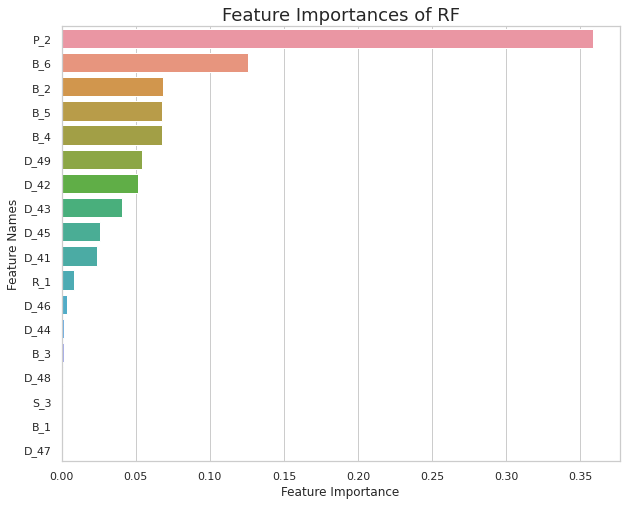

In [156]:
plot_feature_importance(correct_feat_by_imp)

In [157]:
rf_univariate_no_outliers_metrics = compute_metrics(labelCol = 'label')

In [158]:
ytest, ypred = get_ytest_ypred(target_prediction = ['label', 'prediction'])
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88       125
         1.0       0.85      0.93      0.89       118

    accuracy                           0.88       243
   macro avg       0.89      0.89      0.88       243
weighted avg       0.89      0.88      0.88       243



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


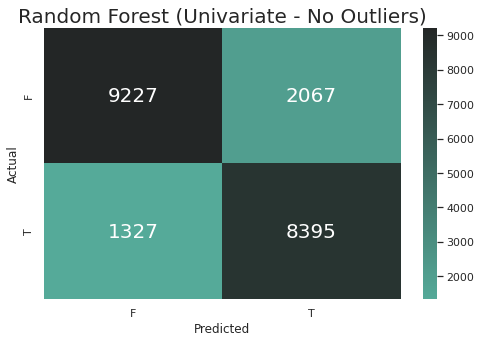

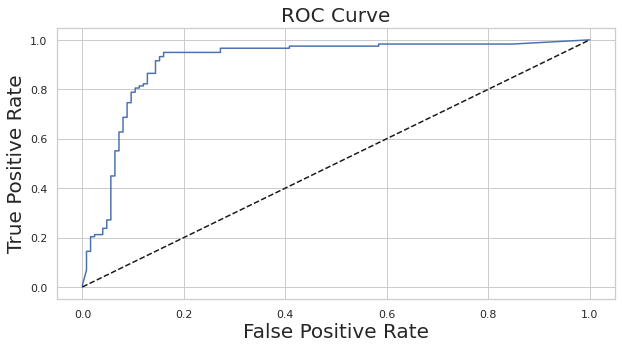

In [159]:
plot_conf_matrix(sns.color_palette("dark:#5A9_r", as_cmap=True), title = 'Random Forest (Univariate - No Outliers)', target_prediction = ['prediction', 'label'])
plot_roc_curve(labelCol = 'label')

### SVM

In [160]:
lsvc = LinearSVC(maxIter=10)
c_values = [10, 1, 0.1, 0.01, 0.001, 0.0001]
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, c_values).build()

In [161]:
tvs = TrainValidationSplit(estimator=lsvc, 
                           estimatorParamMaps=paramGrid, 
                           trainRatio=0.8, evaluator=MulticlassClassificationEvaluator(metricName = 'accuracy'))

model_tvs = tvs.fit(train)

In [162]:
# Check the validation accuracy over each C value 
print("Validation accuracies: ")
list(zip(model_tvs.validationMetrics, c_values))

Validation accuracies: 


[(0.540378624490774, 10),
 (0.829678888090103, 1),
 (0.8414210400191708, 0.1),
 (0.8419602204648934, 0.01),
 (0.8418404025880661, 0.001),
 (0.8417804936496526, 0.0001)]

In [163]:
svm_univariate_no_outliers_metrics = compute_metrics(labelCol = 'label')

### Gradient Boosting Trees

In [164]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(train)
featureIndexer =  VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(train)

In [165]:
model = pipeline.fit(train)
predictions = model.transform(validation)

In [166]:
gbt_univariate_no_outliers_results = compute_metrics(labelCol = 'label')
gbt_univariate_no_outliers_results

{'f1': 0.8339702301413798,
 'accuracy': 0.8337457175485344,
 'recallByLabel': 0.868339847767949,
 'precisionByLabel': 0.7922297297297297}

In [167]:
ytest, ypred = get_ytest_ypred(target_prediction = ['label', 'prediction'])
print(cr(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.91      0.82      0.87       125
         1.0       0.83      0.92      0.87       118

    accuracy                           0.87       243
   macro avg       0.87      0.87      0.87       243
weighted avg       0.87      0.87      0.87       243



In [168]:
#Uploading results to univariate dict
univariate_no_outliers_metrics_dict.update({"dt": dt_univariate_no_outliers_matrics,
                                            "rf": rf_univariate_no_outliers_metrics,
                                            "gbt": gbt_univariate_no_outliers_results,
                                            "svm": svm_univariate_no_outliers_metrics})

univariate_no_outliers_metrics_dict

{'dt': {'f1': 0.832784276539702,
  'accuracy': 0.8325561476969928,
  'recallByLabel': 0.8660769389014606,
  'precisionByLabel': 0.7915765723418257},
 'rf': {'f1': 0.8387294716971831,
  'accuracy': 0.8385039969547011,
  'recallByLabel': 0.8635054515531784,
  'precisionByLabel': 0.8024278340661442},
 'gbt': {'f1': 0.8339702301413798,
  'accuracy': 0.8337457175485344,
  'recallByLabel': 0.868339847767949,
  'precisionByLabel': 0.7922297297297297},
 'svm': {'f1': 0.8387294716971831,
  'accuracy': 0.8385039969547011,
  'recallByLabel': 0.8635054515531784,
  'precisionByLabel': 0.8024278340661442}}

## Classification Dict

In [169]:
classification_dict = {"variance Treshold" : varianceT_metrics_dict,
                       "univariate" : univariate_metrics_dict,
                       "univariate No Outliers" : univariate_no_outliers_metrics_dict}

classification_dict

{'variance Treshold': {'dt': {'f1': 0.8110798292020378,
   'accuracy': 0.8105337447181984,
   'recallByLabel': 0.6255991803578617,
   'precisionByLabel': 0.6148894083797878},
  'rf': {'f1': 0.8104381105211355,
   'accuracy': 0.8178083803078148,
   'recallByLabel': 0.5298766877675729,
   'precisionByLabel': 0.6652119987137672},
  'gbt': {'f1': 0.817173131013379,
   'accuracy': 0.8217985722170448,
   'recallByLabel': 0.5707124300193933,
   'precisionByLabel': 0.6620118845500849},
  'svm': {'f1': 0.6644146152475252,
   'accuracy': 0.7587969707114485,
   'recallByLabel': 0.03351750887335797,
   'precisionByLabel': 0.788975021533161}},
 'univariate': {'dt': {'f1': 0.8505021166469485,
   'accuracy': 0.8495037142262556,
   'recallByLabel': 0.716125727249442,
   'precisionByLabel': 0.6880053434577796},
  'rf': {'f1': 0.854155982171042,
   'accuracy': 0.8552130364365144,
   'recallByLabel': 0.6862307438984229,
   'precisionByLabel': 0.7163209961422405},
  'gbt': {'f1': 0.8553776889960765,
   'a

In [170]:
import pandas as pd
to_table = {(outerKey, innerKey): values for outerKey, innerDict in classification_dict.items() for innerKey, values in innerDict.items()}
pd.DataFrame(to_table)

variance Treshold                               univariate  \
                                dt        rf       gbt       svm         dt   
f1                        0.811080  0.810438  0.817173  0.664415   0.850502   
accuracy                  0.810534  0.817808  0.821799  0.758797   0.849504   
recallByLabel             0.625599  0.529877  0.570712  0.033518   0.716126   
precisionByLabel          0.614889  0.665212  0.662012  0.788975   0.688005   

                                               univariate No Outliers  \
                        rf       gbt       svm                     dt   
f1                0.854156  0.855378  0.861837               0.832784   
accuracy          0.855213  0.854082  0.863076               0.832556   
recallByLabel     0.686231  0.732628  0.697318               0.866077   
precisionByLabel  0.716321  0.694196  0.735281               0.791577   

                                                
                        rf       gbt       svm  
f1                0.838729  0.833970  0.838729  
accuracy          0.838504  0.833746  0.838504  
recallByLabel     0.863505  0.868340  0.863505  
precisionByLabel  0.802428  0.792230  0.802428

# PCA and Clustering
It was applied as an ulterior dimensionality reduction technique on the entire set of features

In [172]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df)

In [173]:
pca_df.show(5)

+--------------------+----------+------+--------------------+--------------------+
|         customer_ID|       S_2|target|            features|        pca_features|
+--------------------+----------+------+--------------------+--------------------+
|000201146e53cacdd...|2017-06-30|   0.0|[0.948,0.12,0.194...|[0.00447638775150...|
|000473eb907b57c8c...|2017-12-08|   1.0|[0.498,0.029,0.69...|[0.00331592938124...|
|00050d84c6d26e26c...|2017-08-25|   0.0|[0.937,0.208,0.03...|[0.00917672842099...|
|00055add5eaee481b...|2017-03-17|   0.0|[0.841,0.002,0.00...|[2.26155357883776...|
|00055add5eaee481b...|2017-07-12|   0.0|[0.834,0.002,0.01...|[0.00814422209149...|
+--------------------+----------+------+--------------------+--------------------+
only showing top 5 rows



In [174]:
sampled_pca_out = pca_df.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42)
data_pca_collected = sampled_pca_out.select('pca_features').collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])

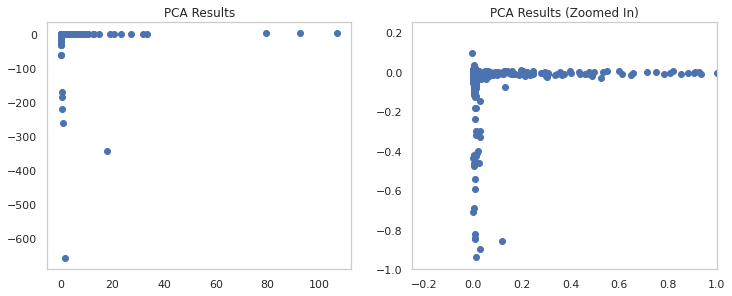

In [175]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1])
plt.grid([])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1])
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.grid([])
plt.show()

In [176]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(assembled_df.select('features'))

# Make predictions
predictions = model.transform(assembled_df.select('features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

# Shows the result.
print(f"Cluster Centers (only the first ten of the first cluster of {len(model.clusterCenters())}): ")
centers = model.clusterCenters()
print(centers[0][:10])

Silhouette with squared euclidean distance = 0.30874936095513184
Cluster Centers (only the first ten of the first cluster of 2): 
[0.75422049 0.10692951 0.02979859 0.87209873 0.02064103 0.13785637
 0.02034517 0.01393005 0.0189258  0.07910084]


In [177]:
cluster_pca = pca_df.join(predictions, 'features')

In [178]:
sampled_pca_out = cluster_pca.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42)
data_pca_collected = sampled_pca_out.select(['pca_features', 'prediction', 'target']).collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])
colors = np.array([row.prediction for row in data_pca_collected])
colors_true = np.array([row.target for row in data_pca_collected])

In [179]:
colors_map = {0 : 'b', 1 : 'r'}
colors = [colors_map[x] for x in colors]
colors_true = [colors_map[x] for x in colors_true]

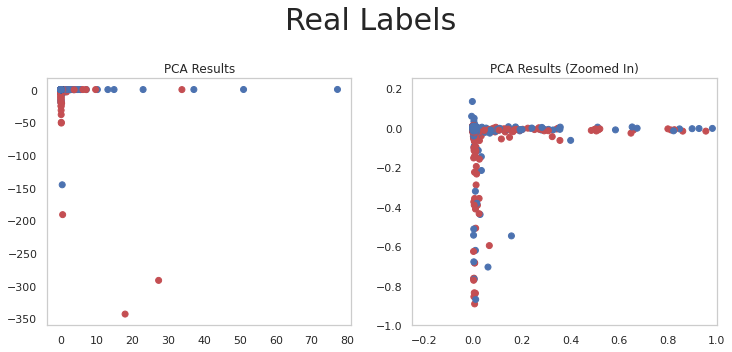

In [180]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)
plt.grid([])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Real Labels', fontsize = 30)
plt.grid([])
plt.show()

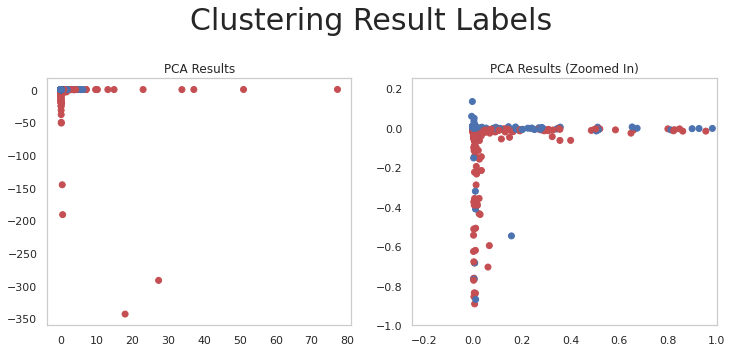

In [181]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)
plt.grid([])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Clustering Result Labels', fontsize = 30)
plt.grid([])
plt.show()

# Geographic Representation

What if we had geographical references for each customer?

## Importing US geometries

In [182]:
from lemma_dev_utils import download_unzip, download
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
import codecs

from skmob.utils.plot import plot_gdf
from shapely.errors import ShapelyDeprecationWarning
import folium

In [183]:
counties = download("https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_050_00_500k.json", "gz_2010_us_050_00_500k.json")

In [184]:
#creating a gpd from the file of the counties
with codecs.open("gz_2010_us_050_00_500k.json", 'r', encoding='utf-8', errors='ignore') as json_file:
    counties_gpd = gpd.read_file(json_file)

# counties_gpd['wkt'] = pd.Series(map(lambda geom: str(geom.wkt), counties_gpd['geometry']), index=counties_gpd.index, dtype='string')
counties_gpd.head()

GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0  0500000US01029    01    029   Cleburne  County     560.100   
1  0500000US01031    01    031     Coffee  County     678.972   
2  0500000US01037    01    037      Coosa  County     650.926   
3  0500000US01039    01    039  Covington  County    1030.456   
4  0500000US01041    01    041   Crenshaw  County     608.840   

                                            geometry  
0  POLYGON ((-85.38872 33.91304, -85.38089 33.873...  
1  POLYGON ((-86.03044 31.61894, -86.00409 31.619...  
2  POLYGON ((-86.00928 33.10164, -86.00917 33.090...  
3  POLYGON ((-86.34851 30.99434, -86.35023 30.994...  
4  POLYGON ((-86.14699 31.68045, -86.14711 31.663...

In [185]:
US_geometry = counties_gpd["geometry"].unary_union
US_geometry

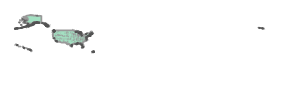

### Creating Lat/Lon Maps

In [186]:
# filtering on only the continental US with territorial continuity
counties_gpd['nation'] = ['USA'] * len(counties_gpd)

US_union = counties_gpd.dissolve(by='nation')
US_geometries = [x for x in US_union['geometry'][0].geoms]
max_idx = np.argmax([x.area for x in US_geometries])
US_geometry = US_geometries[max_idx]
continental_US = gpd.GeoDataFrame(geometry=[US_geometry], crs = counties_gpd.crs)

In [187]:
plot_gdf(continental_US, zoom = 4)

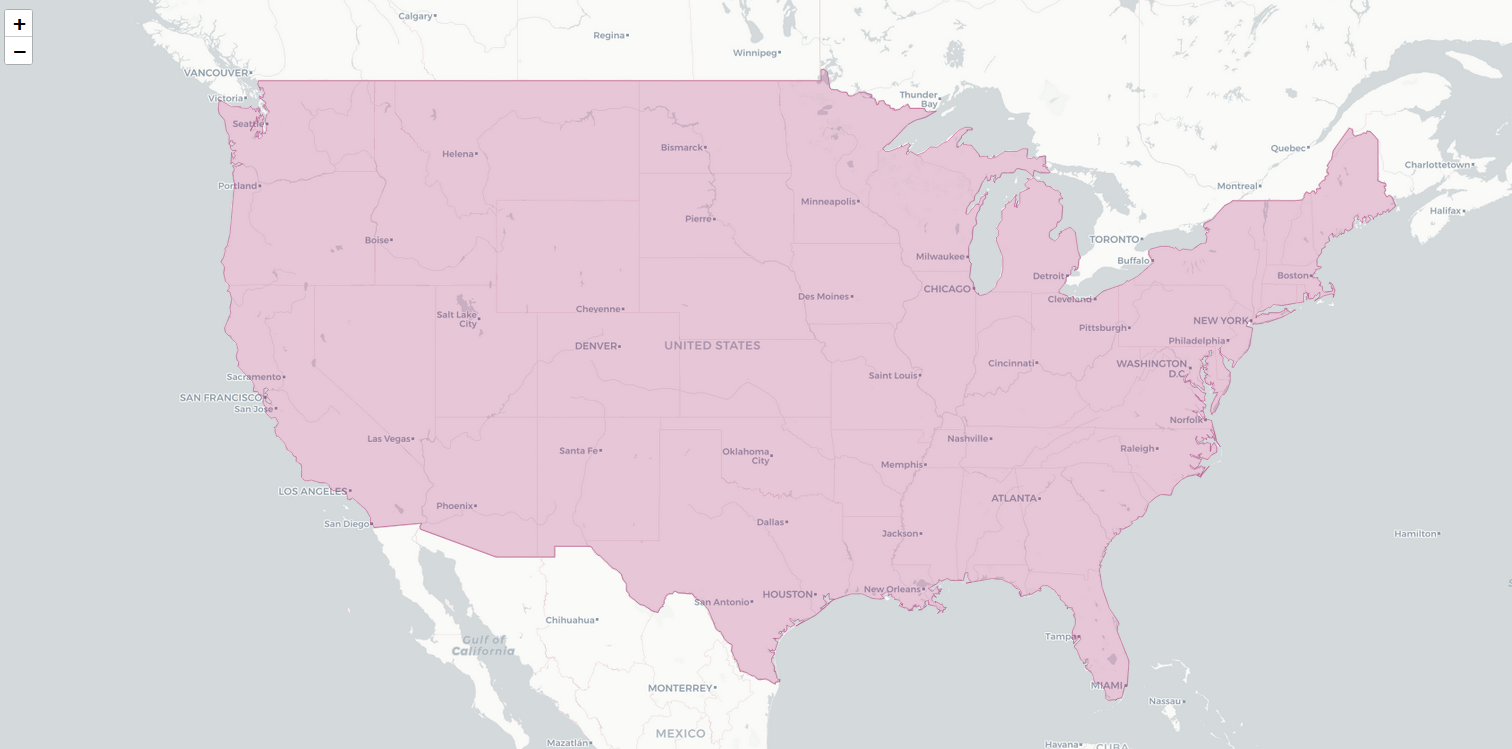

In [188]:
# making a spatial join to get the original states of continental US
continental_counties = gpd.sjoin(counties_gpd, continental_US)

In [189]:
contental_states = continental_counties.dissolve(by='STATE')
plot_gdf(contental_states, zoom = 4)

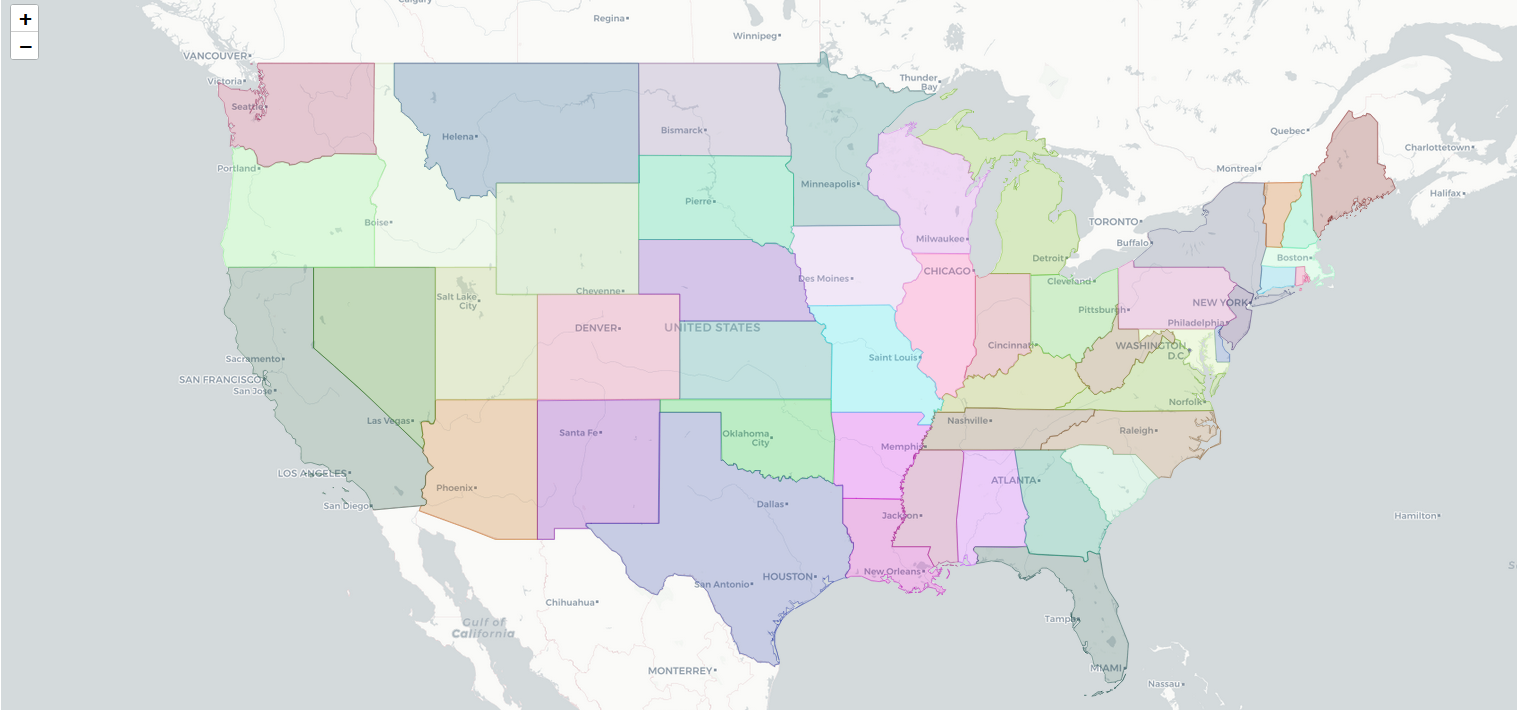

### Mapping customer_IDs with random geoIDs

In [190]:
# n_rows = 10001
geo_ids = continental_counties['GEO_ID'].values

In [191]:
np.random.seed(42)
# mapping each position with a lat/lon array
rdd_latlon = df.select('customer_ID').distinct().rdd.map(lambda x: (x.customer_ID, np.random.choice(geo_ids)))

In [192]:
#converting rdd to df
latlon_df = rdd_latlon.toDF() #to get stringType without importing it
for old_col, new_col in zip(latlon_df.columns, ['customer_ID', 'GEO_ID']):
    latlon_df = latlon_df.withColumnRenamed(old_col, new_col)
latlon_df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- GEO_ID: string (nullable = true)



In [193]:
latlon_df.show(5)

+--------------------+--------------+
|         customer_ID|        GEO_ID|
+--------------------+--------------+
|000201146e53cacdd...|0500000US31053|
|000473eb907b57c8c...|0500000US54025|
|0004e00358fc4dd63...|0500000US24041|
|00050d84c6d26e26c...|0500000US48237|
|00055add5eaee481b...|0500000US48201|
+--------------------+--------------+
only showing top 5 rows



### Joining tables

Each customer_ID has it's own GeoID, even tho the customer is repreated

In [194]:
union_df = df.join(latlon_df, on = 'customer_ID')

In [195]:
union_df.select('customer_ID').distinct().count()

323285

In [196]:
union_df.select(['customer_ID', 'GEO_ID']).distinct().count()

323285

In [197]:
union_df.show(1)

+--------------------+----------+-----+----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+---+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+----+-----+-----+----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+----

In [198]:
# overall columns
cols = union_df.columns

#D_* starting columns
d_columns = [col for col in cols if col[0].lower() == "d"]
d_columns[:5]

['D_39', 'D_41', 'D_42', 'D_43', 'D_44']

## Selecting and ajusting feature to plot

In [199]:
# Extragning column Variance from "D_*" columns
variances = df.agg({col : "variance" for col in d_columns if str(df.schema[col].dataType) != 'VectorUDT()'}).collect()
d_var = list(variances[0].asDict().items())

# dropping None Values as variance
d_variances = [(k,v) for k, v in d_var if v is not None]
d_variances[:5]

[('variance(D_74)', 0.04797851507666105),
 ('variance(D_55)', 0.0834712324862824),
 ('variance(D_70)', 0.05081055231877847),
 ('variance(D_81)', 0.11887549029980762),
 ('variance(D_92)', 0.08638976349846345)]

In [200]:
# Extracting Variance of D_39
# sorted_max = sorted(d_variances, key=lambda x: -x[1])

var_col = d_columns[0] # "D_39"

print("Variance_column:", var_col)
print([x for x in d_variances if var_col in x[0]][0])

Variance_column: D_39
('variance(D_39)', 0.07296821477698014)


In [201]:
#Calculating Column Median
median = union_df.approxQuantile(var_col, [0.5], 0.1)[0]
print("Median:", median)

Median: 0.008


In [202]:
#Sintetizing new exponential column
filtered_df = union_df.withColumn("new_D_col", e**(f.col(var_col)+10))

In [203]:
#Sampling the data frame as a good spark manner
sample_filtered_df = filtered_df.sample(withReplacement = False, fraction = SAMPLE_FRAC, seed = 42)

# Filtering for the columns we want and making the df a Pandas Object to work on
to_plot_df = sample_filtered_df.select(['customer_ID', 'new_D_col', 'GEO_ID'])
to_plot_pdf_pre = to_plot_df.toPandas()

#merging the df with original geopandas df by "GEO_ID" key
to_plot_pdf = to_plot_pdf_pre.merge(continental_counties, on = 'GEO_ID')

#Dissolving geometry by STATE dimension
to_plot_gdf = gpd.GeoDataFrame(
                    to_plot_pdf[['customer_ID', 'STATE', 'new_D_col']]\
                    .merge(continental_counties.dissolve(by='STATE').reset_index()[['geometry', 'STATE']], on='STATE')
                    )

to_plot_gdf.head()

customer_ID STATE     new_D_col  \
0  0072650fe3b2b1f69280201b9128f0801e9c578b257690...    26  22092.644410   
1  05a9c9801ffae27a400a569c9bae186fcb156019cc9a99...    26  39695.773498   
2  0093eadd4906802531774fa16eca13fab8ac1dd796dcae...    26  42361.702918   
3  7981f895bd4cbad6720553fb2dd156f9735d3a60b04f3a...    26  22159.021860   
4  0370cc7ce0a0ae8254126ec2e16707b99455619bf9bf5c...    26  22203.384251   

                                            geometry  
0  MULTIPOLYGON (((-85.97498 41.75985, -85.99130 ...  
1  MULTIPOLYGON (((-85.97498 41.75985, -85.99130 ...  
2  MULTIPOLYGON (((-85.97498 41.75985, -85.99130 ...  
3  MULTIPOLYGON (((-85.97498 41.75985, -85.99130 ...  
4  MULTIPOLYGON (((-85.97498 41.75985, -85.99130 ...

## Plotting the map

In [204]:
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

aggregated_by_state = to_plot_gdf.groupby('STATE').agg(list).reset_index()

In [205]:
aggregated_by_state['geometry'] = aggregated_by_state['geometry'].map(lambda x: x[0])

In [206]:
aggregated_by_state = gpd.GeoDataFrame(aggregated_by_state[['STATE', 'geometry']])

In [207]:
path = os.getcwd()+'/for_choropleth.geojson'
aggregated_by_state.to_file(path, driver="GeoJSON")

In [208]:
aggregated_by_state.head()

STATE                                           geometry
0    01  MULTIPOLYGON (((-88.07485 30.24912, -88.07586 ...
1    04  POLYGON ((-112.56252 31.80188, -112.60779 31.8...
2    05  POLYGON ((-93.39593 33.01831, -93.46704 33.018...
3    06  MULTIPOLYGON (((-122.33321 37.59146, -122.3176...
4    08  POLYGON ((-106.34314 36.99423, -106.47628 36.9...

In [209]:
custom_scale = (to_plot_gdf['new_D_col'].quantile((0,0.2,0.4,0.6,0.8,0.9,1))).tolist()

us_map = folium.Map(location=(US_geometry.centroid.y, US_geometry.centroid.x), zoom_start=4)

folium.Choropleth(
            geo_data=path,
            data=to_plot_gdf,
            columns=['STATE', 'new_D_col'],  #Here we tell folium to get the county fips and plot new_cases_7days metric for each county
            key_on='feature.properties.STATE', #use the custom scale we created for legend
            fill_color='YlOrBr',
            fill_opacity = 0.7,
            line_opacity = 0.2,
            legend_name="Delinquency Rate").add_to(us_map)

us_map

Having used these made up data just to explore a possible geographic processing of the data, the assignment of geoid to customer is a random choice and there is no real meaning to the countries highlighted other thant the fact they were randomly picked as having a higher "delinquency". We saved one output to show as it was a little bit more colorful than the others (reflecting a little bit of imbalance

A screenshot of the output:

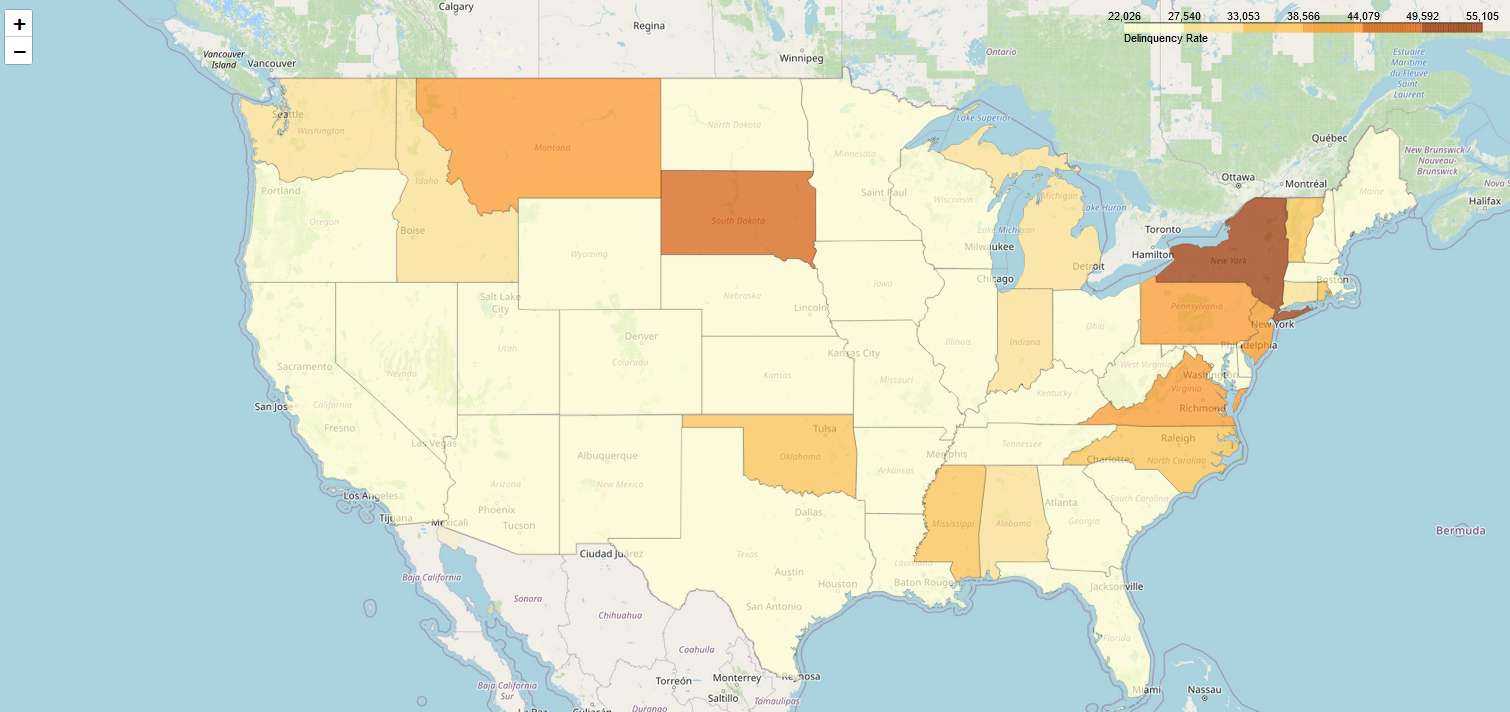

# Test Set: Predictions and Aggregation by Customer

In [210]:
print(sorted(sel_feat_expl))

['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'P_2', 'R_1', 'R_2', 'S_3']


In [211]:
print(sorted(categorical_variables))

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


In [212]:
[x for x in sel_feat_expl if x in categorical_variables]

[]

In [213]:
os.chdir('/content/dataset/')

test_df = spark.read.format("csv") \
          .option("header", True) \
          .schema(df_schema) \
          .load("/content/dataset/test_data.csv")

test_df = test_df.select(['customer_ID', 'S_2'] + sel_feat_expl)
test_df = test_df.fillna(0.0)

# assembling features
vecAssembler = VectorAssembler(inputCols=sel_feat_expl, outputCol="features")
test_df = vecAssembler.transform(test_df).select(['customer_ID', 'S_2']+['features'])
test_df.show(5)

+--------------------+----------+--------------------+
|         customer_ID|       S_2|            features|
+--------------------+----------+--------------------+
|00000469ba478561f...|2019-02-19|[0.63131534887012...|
|00000469ba478561f...|2019-03-25|[0.58704226004969...|
|00000469ba478561f...|2019-04-25|[0.60905608639949...|
|00000469ba478561f...|2019-05-20|[0.61491117320464...|
|00000469ba478561f...|2019-06-15|[0.59167280019467...|
+--------------------+----------+--------------------+
only showing top 5 rows



In [214]:
predictions = best_model.transform(test_df)
predictions.show(5)

+--------------------+----------+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|            features|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+--------------------+----------+
|00000469ba478561f...|2019-02-19|[0.63131534887012...|[9.54047247825999...|[0.31801574927533...|       1.0|
|00000469ba478561f...|2019-03-25|[0.58704226004969...|[7.60017120714051...|[0.25333904023801...|       1.0|
|00000469ba478561f...|2019-04-25|[0.60905608639949...|[8.98255182315673...|[0.29941839410522...|       1.0|
|00000469ba478561f...|2019-05-20|[0.61491117320464...|[7.46068685119307...|[0.24868956170643...|       1.0|
|00000469ba478561f...|2019-06-15|[0.59167280019467...|[7.54286211736834...|[0.25142873724561...|       1.0|
+--------------------+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [215]:
predictions = predictions.select('customer_ID', 'probability')
predictions = predictions.rdd.map(lambda x: (x.customer_ID, float(x.probability[1]))).toDF(['customer_ID', 'probability'])

In [216]:
output = predictions.groupBy(['customer_ID']).mean('probability')

In [217]:
output.show(5)

+--------------------+-------------------+
|         customer_ID|   avg(probability)|
+--------------------+-------------------+
|00004ffe6e01e1b68...|0.07070453463318217|
|00048ea2f1b75bb67...| 0.8529255125880646|
|001d908c73a0ee372...| 0.5659474794308479|
|0022f9fde71c6d3bc...|  0.724961186672546|
|00323fa8e0aca38d4...| 0.8026889705649431|
+--------------------+-------------------+
only showing top 5 rows



In [223]:
output_pd = output.toPandas().reset_index(drop = True)
output_pd.columns = ['customer_ID', 'prediction']

In [224]:
output_pd.to_csv('/content/drive/Shareddrives/Mie Robe/large_sample_submission.csv', index = False)